# **Our fifth numerical adventure(!!) - Trigonometric interpolation and wavelets**

*Group: 8008*

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.fft

import warnings
warnings.filterwarnings('ignore')

from matplotlib import image

from numba import jit

**Remark: This notebook should be opened in VSCode**

### **Task 1**

Define the inner product on $L^2(\mathbb{T})$ to be

\begin{align*}
    \langle f,g\rangle = \int_\mathbb{T} f(t) \overline {g(t)} \space dt
\end{align*}

**1a)**

Consider the family of functions $\left \{e^{2 \pi i k x}\right \}_{k \in \mathbb{Z}}$ on $\mathbb{T}$. We claim this family to  be an orthonormal family of function. For convenience, call them $f_n$ in the natural order. It might be worth pointing out that $\overline {f_n} = f_{-n} \space \forall n \in \mathbb{Z}$

Assume $m = n$:

\begin{align*}
    \langle f_n, f_m \rangle &= \int_\mathbb{T} f_n(t) \overline {f_m(t)} \space dt \\
    &= \int_0^1 e^{2 \pi i n t} e^{-2 \pi i m t} \space dt \\
    &= \int_0^1 dt \\
    &= 1
\end{align*}

Assume now $m \neq n$. Thus, $m - n$ is necessarily a nonzero integer:

\begin{align*}
    \langle f_n, f_m \rangle &= \int_\mathbb{T} f_n(t) \overline {f_m(t)} \space dt \\
    &= \int_0^1 e^{2 \pi i n t} e^{-2 \pi i m t} \space dt \\
    &= \int_0^1 e^{2 \pi i (n - m) t} \space dt \\
    &= \frac{1}{2 \pi i (n - m)} e^{2 \pi i (n - m) t} \bigg|_{t = 0}^{t = 1} \\
    &= \frac{1}{2 \pi i (n - m)} \left( e^{2 \pi i (n - m)} - 1\right ) \\
    &= \frac{1}{2 \pi i (n - m)} \left( 1 - 1\right ) \\
    &= 0
\end{align*}

The claim follows.

$\square$

**1b)**

We proceed to show that the functions $\sqrt{2}\sin(2\pi m x)$ and $\sqrt{2}\cos(2\pi n x)$, for $m, n \in \mathbb{N}$ and $x \in \mathbb{T}$, forms an orthogonal system.

We know $\sin(x) = \frac{e^{ix} - e^{-ix}}{2i}$ and $\cos(x) = \frac{e^{ix} + e^{-ix}}{2}$. Immediately we have

\begin{align*}
    \sin(2 \pi n x) &= \frac{e^{2 \pi i n x} - e^{-2 \pi i n x}}{2i} \\
    &= \frac{f_n(x) - f_{-n}(x)}{2i} \\
    \cos(2 \pi n x) &= \frac{e^{2 \pi i n x} + e^{-2 \pi i n x}}{2} \\
    &= \frac{f_n(x) + f_{-n}(x)}{2} \\
\end{align*}

Considering first the symmetric cases.
\begin{align*}
    \langle \sqrt{2} \sin(2 \pi n \cdot), \sqrt{2} \sin(2 \pi m \cdot) \rangle &= \frac{ \langle f_n - f_{-n}, f_m - f_{-m} \rangle}{2} \\
    &= \frac{1}{2} \langle f_n - f_{-n}, f_m - f_{-m} \rangle \\
    &= \frac{1}{2} ( \langle f_n, f_m \rangle - \langle f_n, f_{-m} \rangle - \langle f_{-n}, f_{m} \rangle + \langle f_{-n}, f_{-m} \rangle) \\
\end{align*}
In the first equality, the $i$'s cancles, by sesquilinearity. From the property derived in task 1a) we clearly have:

$$
\langle\sqrt{2} \sin (2 \pi n \cdot), \sqrt{2} \sin (2 \pi m \cdot)\rangle=\left\{\begin{array}{ll}
0 & \text { if } m \neq n, \\
1 & \text { if } m=n,
\end{array} \quad m, n \in \mathbb{N} \right.
$$

Analogously, we can examine $\langle \sqrt{2} \cos(2 \pi n \cdot), \sqrt{2} \cos(2 \pi m \cdot) \rangle$ in the same manner:

\begin{align*}
    \langle \sqrt{2} \cos(2 \pi n \cdot), \sqrt{2} \cos(2 \pi m \cdot) \rangle &= \frac{ \langle f_n + f_{-n}, f_m + f_{-m} \rangle}{2} \\
    &= \frac{1}{2} \langle f_n + f_{-n}, f_m + f_{-m} \rangle \\
    &= \frac{1}{2} ( \langle f_n, f_m \rangle + \langle f_n, f_{-m} \rangle + \langle f_{-n}, f_{m} \rangle + \langle f_{-n}, f_{-m} \rangle) \\
\end{align*}

Keep in mind now that $n,m$ can now reach index $0$. When $n$ and $m$ differs from $0$, the results are identical to sine. However, when $ n = m = 0$ we also have $m = - m = n = -n$ meaning this special case will give $2$!

Same argument as previously used, we have:

$$
\langle\sqrt{2} \cos (2 \pi n \cdot), \sqrt{2} \cos (2 \pi m \cdot)\rangle=\left\{\begin{array}{ll}
0 & \text { if } m \neq n, \\
1 & \text { if } m=n \neq 0, \\
2 & \text{ if } m = n = 0
\end{array} \quad m, n \in \mathbb{N}_0 \right.
$$

$\mathbb{N}_0$ denotes the nonnegative integers

Lastly:
\begin{align*}
    \langle \sqrt{2} \sin(2 \pi n \cdot), \sqrt{2} \cos(2 \pi m \cdot) \rangle &= \frac{ \langle f_n - f_{-n}, f_m + f_{-m} \rangle}{2i} \\
    &= \frac{1}{2i} \langle f_n - f_{-n}, f_m + f_{-m} \rangle \\
    &= \frac{1}{2i} ( \langle f_n, f_m \rangle + \langle f_n, f_{-m} \rangle - \langle f_{-n}, f_{m} \rangle - \langle f_{-n}, f_{-m} \rangle) \\
\end{align*}

This time, when  $n = m$, the two non-zero terms, $\langle f_n, f_m \rangle$ and $\langle f_{-n}, f_{-m} \rangle$, cancels. Therefore, we have  
$$
\langle \sqrt{2} \sin(2 \pi n \cdot), \sqrt{2} \cos(2 \pi m \cdot) \rangle = 0, \space n \in \mathbb{N}, m \in \mathbb{N}_0 
$$ 

**1c)**

We now introduce the following spaces:

\begin{align*}
\mathcal{T}_n &\triangleq \operatorname{\text{span}}\left(\mathrm{e}^{-2 \pi \mathrm{i} n}, \ldots, \mathrm{e}^{2 \pi \mathrm{i} n \cdot}\right)=\left\{f \space \Bigg| \space  f(x)=\sum_{k=-n}^n c_k \mathrm{e}^{2 \pi \mathrm{i} k x}, \quad \text { where } c_{-n}, c_{-n+1}, \ldots, c_n \in \mathbb{C} \wedge c_{k} = \overline{c_{-k}},\space k \in \{0, \ldots, n\} \right\} \\
\mathcal{S}_n & \triangleq \operatorname{\text{span}}(\cos (0 \cdot), \cos (2 \pi \cdot), \ldots, \cos (2 \pi n \cdot), \sin (2 \pi \cdot), \sin (2 \pi 2 \cdot), \ldots, \sin (2 \pi n \cdot)) \\
&=\left\{f \space \Bigg | \space f(x)=\frac{a_0}{2}+\sum_{k=1}^n a_k \cos (2 \pi k x)+b_k \sin (2 \pi k x), \text { where } a_0, a_1, \ldots, a_n, b_1, \ldots, b_n \in \mathbb{R}\right\}
\end{align*}

As it is given, both the basis for $\mathcal{T}_n$ and $\mathcal{S}_n$ is orthogonal, we only need to normalize each vector. We recall that the inner product $\langle \cdot, \cdot \rangle$ induces the norm $\| x \| = \sqrt{ \langle x, x \rangle }$. Using this we can achive the orthonormal bases $\{\beta_i\}_{i=-n}^{n}$ and $\{\gamma_i\}_{i=0}^{2n + 1}$ for $\mathcal{T}_n$ and $\mathcal{S}_n$ respectively. 

Eariler we proved that the basis provided for $\mathcal{T}_n$ are both orthogonal and normal. Defining  $\beta_i \triangleq \frac{f_i}{\|f_i\|} = f_i$, yields an orthonormal basis for $\mathcal{T}_n$.

Now denote
$
s_i = \begin{cases}1 & \text { if } i = 0, \\ 
\cos (2 \pi i \cdot) & \text { if } 1 \leq i \leq n, \\
\sin (2 \pi (i-n) \cdot) & \text { else } \end{cases}  
$

$1$ denotes the constant function equal to the value $1$. 

It seems quirky, but we need a way to index them. As eariler shown, these funtions are orthogonal but not necessarily normal. We use the same procedure as eariler, that is $\gamma_i \triangleq \frac{s_i}{\|s_i\|} $. We have $\|s_n\| = \sqrt{\langle s_n, s_n\rangle} = \frac{1}{\sqrt{2}}$ for $n \geq 1$. $s_0$ is normallized. An orthonormal basis for $\mathcal{S_n}$ will be given by $\{\gamma_i\}_{i = 0}^{2 n + 1}$. Where $\gamma_0 = 1$ and $\gamma_i = \sqrt{2} s_i$ for $i \geq 1$

***Claim*** $\mathcal{T}_n = \mathcal{S}_n$

Consider an arbitrary element $\zeta = \sum_{k=-n}^n c_k \mathrm{e}^{2 \pi \mathrm{i} k x}$ in $\mathcal{T}_n$. Reformulate this using Euler's formula.

\begin{align*}
\zeta &= \sum_{k=-n}^n c_k \mathrm{e}^{2 \pi \mathrm{i} k x} = \sum_{k=-n}^n c_k ( \cos(2 \pi k x) + i \sin(2 \pi k x) ) \\
\end{align*} 

Observe that $c_{-k} = \overline{c_k}, \space k \in \{0, \ldots, n\}$. Hence, this sum can more conveniently be expressed like this:

\begin{align*}
\zeta &= c_0 + \sum_{k=1}^n c_k ( \cos(2 \pi k x) + i \sin(2 \pi k x) ) + c_{-k}( \cos(- 2 \pi k x) + i \sin(- 2 \pi k x) ) \\
      &= c_0 + \sum_{k=1}^n c_k ( \cos(2 \pi k x) + i \sin(2 \pi k x) ) + \overline{c_{k}}( \cos(2 \pi k x) - i \sin(2 \pi k x) ) \\
      &= c_0 + \sum_{k=1}^n (c_k + \overline{c_k}) \cos(2 \pi k x) + i (c_k - \overline{c_k}) \sin(2 \pi k x) ) \\
      &= c_0 + \sum_{k=1}^n 2\Re \{c_k\} \cos(2 \pi k x) + 2 i \Im \{c_k\}  \sin(2 \pi k x) \\
\end{align*}

Obviously $c_0 = \overline{c_0} \implies c_0 \in \R$. Furthermore, we have $2\Re \{c_k\}, 2i \Im \{c_k\} \in \R$. Thereby, we can express $\zeta$ interms of real coefficients.

\begin{align*}
\zeta &= c_0 + \sum_{k=1}^n 2\Re \{c_k\} \cos(2 \pi k x) + 2 i \Im \{c_k\}  \sin(2 \pi k x) \\
      &= \widetilde{a_0} + \sum_{k=1}^n \widetilde{a_k} \cos(2 \pi k x) + \widetilde{b_k}  \sin(2 \pi k x), \quad \widetilde{a_0}, \widetilde{a_k}, \widetilde{b_k} \in \R, \space k \in \{1, \ldots, n \}
\end{align*}

From this we observe that $\mathcal{T}_n \subseteq \mathcal{S}_n \implies \text{\text{span}} \{\beta_n\}_n \subseteq \text{\text{span}} \{\gamma_n\}_n$. Furthermore, we know there is $2n + 1$ elements in both $\{\beta_n\}_n$ and $\{\gamma_n\}_n$; thus, the two spaces are the same, with dimension $2n + 1$.

$\square$

**1d)**

By assumption, $f \in \mathcal{S}_n$. Therefore, 

\begin{align*}
    f = \frac{a_0}{2} + \sum_{k = 1}^n a_k\cos (2 \pi k x) + b_k\sin(2 \pi k x), \quad a_i, b_i \in \mathbb{R}
\end{align*}

If we now utilize that inner products are sesquilinear, we get:

\begin{align*}
    \langle f,\cos(2\pi l \cdot)\rangle &= \left \langle \frac{a_0}{2} + \sum_{k = 1}^n a_k\cos (2 \pi k \cdot) + b_k\sin(2 \pi k \cdot),\cos(2\pi l \cdot) \right \rangle \\
    &= \left \langle \frac{a_0}{2} ,\cos(2\pi l \cdot) \right \rangle + \sum_{k = 1}^n a_k \left \langle\cos (2 \pi k \cdot)  ,\cos(2\pi l \cdot) \right \rangle + \sum_{k = 1}^n b_k \left \langle\sin (2 \pi k \cdot)  ,\cos(2\pi l \cdot) \right \rangle \\
\end{align*}

We have seen that $\sin (2 \pi k \cdot)  ,\cos(2\pi l \cdot)$ are orhtogonal. These terms will just vanish. From **1b)** we can further conclude $ \langle\cos (2 \pi k \cdot)  ,\cos(2\pi l \cdot) \rangle = \frac{\delta_{lk}}{2}$ for $k \geq 1$. Lastly, $\frac{a_0}{2} = \frac{a_0}{2}\cos(2\pi 0 \cdot)$ which means $\langle \frac{a_0}{2},\cos(2\pi l \cdot)\rangle = \frac{a_0}{2} \delta_{0l}$. We get


\begin{align*}
    &= \left \langle \frac{a_0}{2} ,\cos(2\pi l \cdot) \right \rangle + \sum_{k = 1}^n a_k \left \langle\cos (2 \pi k \cdot)  ,\cos(2\pi l \cdot) \right \rangle + \sum_{k = 1}^n b_k \left \langle\sin (2 \pi k \cdot)  ,\cos(2\pi l \cdot) \right \rangle \\
    &=  \frac{a_0}{2} \delta_{0l} + \sum_{k = 1}^n a_k \frac{\delta_{kl}}{2} + \sum_{k = 1}^n b_k \cdot 0 \\
    &= \sum_{k = 0}^n a_k \frac{\delta_{kl}}{2} \\
    &= \frac{a_l}{2}
\end{align*}

Solving for $a_l$ we get.


\begin{align*}
    a_l = 2 \left \langle f,\cos(2 \pi l \cdot) \right \rangle = 2 \int_{-\frac{1}{2}}^{\frac{1}{2}} f(x)\cos(2 \pi l x) dx
\end{align*}

It is analogous for $\sin(2 \pi l \cdot)$ 
\begin{align*}
    b_l = 2 \left \langle f,\sin(2 \pi l \cdot) \right \rangle = 2 \int_{-\frac{1}{2}}^{\frac{1}{2}} f(x)\sin(2 \pi l x) dx
\end{align*}


**1e)**

We have $c_k=c_k(f)=\left\langle f, \mathrm{e}^{2 \pi \mathrm{i} k \cdot}\right\rangle=\int_{-\frac{1}{2}}^{\frac{1}{2}} f(x) \mathrm{e}^{-2 \pi \mathrm{i} k x} \mathrm{~d} x, \quad k=-n, \ldots, n$, and we want to approximate this using the composite trapezoidal rule with equidistant points $x_0, \ldots, x_N$. Considering both $f$ and $e^{-2 \pi i k \cdot}$ are periodic with period $1$, we can apply the composite trapezoidal rule on the interval $[0, 1)$. This yields:

\begin{align*}
c_k(f) \approx \hat{f}_k \triangleq \Delta x\left(\sum_{j=1}^{N-1} f_j e^{-2 \pi i k x_j} +\frac{f_N e^{-2 \pi i k x_N}+f_0 e^{-2 \pi i k x_0}}{2}\right), \text{ where } \Delta x = \frac{1}{N} \space \wedge \space  x_j = \frac{j}{N}, \space j \in \{0, 1, \ldots, N\}
\end{align*}

Observe that $f_N = f_0$, since $f$ is $1$ periodic. Furthermore, the expression $e^{-2 \pi i k x_N} = e^{-2 \pi i k}$ simplifies to $1$ since $k \in \Z$. Moreover, $e^{-2 \pi i k x_0} = 1$ since $x_0 = 0$. 

Hence, $\hat{f}_k = \Delta x\left(\sum_{j=1}^{N-1} f_j e^{-2 \pi i k x_j} + f_0\right) = \frac{1}{N} \sum_{j=0}^{N-1} f_j e^{-2 \pi i k x_j} = \frac{1}{N} \sum_{j=0}^{N-1} f_j e^{-2 \pi i k \frac{j}{N}} $

By the definition of we have

\begin{align}
    \hat{f}_k &= \frac{1}{N} \sum_{j = 0}^{N-1} f_j e^{-2 \pi i k \frac{j}{N}} \\
    \implies \hat{f}_{k+N} &= \frac{1}{N} \sum_{j = 0}^{N-1} f_j e^{-2 \pi i (k+N) \frac{j}{N}} \\
    &= \frac{1}{N} \sum_{j = 0}^{N-1} f_j e^{-2 \pi i k \frac{j}{N}} e^{-2 \pi i N \frac{j}{N}} \\
    &= \frac{1}{N} \sum_{j = 0}^{N-1} f_j e^{-2 \pi i k \frac{j}{N}} e^{-2 \pi i j} \\
    &= \frac{1}{N} \sum_{j = 0}^{N-1} f_j e^{-2 \pi i k \frac{j}{N}} \\
    &= \hat{f}_k
\end{align}

proving $\hat{f}_k \space N$-periodic

A well known result from fourier analysis is the Riemann-Lebesgue lemma. It states that for any $f$. 

\begin{align*}
    \lim_{|k| \rightarrow \infty} c_k(f) = 0
\end{align*}

Now since $\hat{f}_k$ is $N$ periodic the approximation will not work for small or big values of $k$. Why? Assume $\hat{f}_k \neq 0$. Since 

$$0 \neq \hat{f}_l = \lim_{|k| \rightarrow \infty} \hat{f}_{l + kN} \approx \lim_{|k| \rightarrow \infty} c_{l+kN}(f) =0$$

Which indicates that the approximation is bad for large values of $k$.

**1f)**

Let $N \in \N$ and $k \in \Z$ be given.

***Claim:*** $\frac{1}{N} \sum_{j=0}^{N-1} \mathrm{e}^{-2 \pi \mathrm{i} j k / N}= \begin{cases}1 & \text { if } k \equiv 0 \bmod N \\ 0 & \text { else }\end{cases}$

Lets examine the case where $k \equiv 0 \bmod N$, that is $k = \alpha N, \space \alpha \in \Z$. 

\begin{align*}
\frac{1}{N} \sum_{j=0}^{N-1} \mathrm{e}^{-2 \pi \mathrm{i} j k / N} &= \frac{1}{N} \sum_{j=0}^{N-1} \mathrm{e}^{-2 \pi \mathrm{i} j \alpha N / N} 
= \frac{1}{N} \sum_{j=0}^{N-1} \mathrm{e}^{-2 \alpha \pi \mathrm{i} j} = \frac{1}{N} \sum_{j=0}^{N-1} (\mathrm{e}^{-2 \pi \mathrm{i}})^{\alpha j} 
= \frac{1}{N} \sum_{j=0}^{N-1} 1^{\alpha j} = \frac{1}{N} \sum_{j=0}^{N-1} 1 =  \frac{N}{N} = 1 
\end{align*}

Examining the case where $k ≠ \alpha N$, we proceed by viewing the summation as the $N'th$ partial sum of a geometric series with ratio $e^{-2 \pi i k/N}$. Thus, we obtain the expression below:

\begin{align*}
\frac{1}{N} \sum_{j=0}^{N-1} \mathrm{e}^{-2 \pi \mathrm{i} j k / N} = \frac{1}{N} \sum_{j=0}^{N-1} (\mathrm{e}^{-2 \pi \mathrm{i} k / N})^j 
= \frac{1 - (\mathrm{e}^{-2 \pi \mathrm{i} k / N})^N }{1 - \mathrm{e}^{-2 \pi \mathrm{i} k / N}} 
= \frac{1 - \mathrm{e}^{-2 \pi \mathrm{i} k} }{1 - \mathrm{e}^{-2 \pi \mathrm{i} k / N}} = 0
\end{align*}

The claim follows.

$\square$

**1g)**

Given a vector $\textbf{a} = (a_0, \ldots, a_{N-1})^T$ and the Fourier matrix $\mathcal{F}_N$ we claim the following.

***Claim: $\text{circ} (\textbf{a}) = N^2 \overline{\mathcal{F}_N} \space \text{diag}(\hat{\textbf{a}}) \space \mathcal{F}_N, \quad$*** *where* ***$\hat{\textbf{a}} = \mathcal{F}_N\textbf{a}$***

Consider the permutation $\tau: \{1, 2, \ldots, N\} \rightarrow \{N, 1, \ldots, N - 1\}$ on $N$ elements. This permutation can be represented by the matrix $P_{\tau}$.

$$
P_{\tau} = 
\begin{bmatrix} 
0 & 0 & \ldots & 1 \\
1 & \ddots & \ddots & \vdots \\
\vdots & \ddots & \ddots & 0 \\
0 & \ldots & 1 & 
\end{bmatrix} 
$$

Any circulant matrix can be expressend in terms of powers of this matrix, i.e. $\text{circ} (\textbf{a}) = a_0 I + a_1 P_{\tau} + a_2 + P_{\tau}^2 + \cdots + a_{N-1} P_{\tau}^{N-1}$. The eigenvalues of $P_{\tau}$, is exactly the values satisfying $\lambda^N = 1$, i.e. every N'th root of unity. Clearly $P_{\tau}$ is of full rank. Moreover, it can be shown that every eigenvector of the permutation matrix is an eigenvector of $\text{circ} (\textbf{a})$. Consider an eigenvector, $\tilde{x}$ of $P_{\tau}$:

\begin{align*}
\text{circ}(\textbf{a}) \tilde{x} &= (a_0 I + a_1 P_{\tau} + a_2 P_{\tau}^2 + \cdots + a_{N-1} P_{\tau}^{N-1})\tilde{x}  \\
                            &= a_0 I \tilde{x} + a_1 P_{\tau} \tilde{x} + a_2  P_{\tau}^2 \tilde{x} + \cdots + a_{N-1} P_{\tau}^{N-1} \tilde{x}  \\
                            &= a_0 I \tilde{x} + a_1 \lambda \tilde{x} + a_2  \lambda^2 \tilde{x} + \cdots + a_{N-1} \lambda^{N-1} \tilde{x}  \\
                            &= (a_0 + a_1 \lambda  + a_2  \lambda^2 + \cdots + a_{N-1} \lambda^{N-1}) \tilde{x} = \xi \tilde{x}, \quad  \xi \in \mathbb{C}
\end{align*}

We also note that the eigenvalues $\xi$ of $\text{circ}(\textbf{a})$ is of the form $\xi_k = \sum_{j = 0}^{N - 1} a_j \lambda_k^{j}$, where $\lambda_k$ is the k'th N'th root of unity. We have know seen that every circulent matrix share the eigenvectors of $P_{\tau}$. This is sufficient to show that any two circulent matricies commute.

***Claim:*** two circulent matricies $A, B \in \mathbb{C}^{N \times N}$ commutes.

***Proof:***

let $\zeta \in \mathbb{C}^N$ be an eigenvector of $P_{\tau} \in \mathbb{C}^{N \times N}$. Thus, $\zeta$ is an eigenvector of both $A$ and $B$. Let $\lambda, \mu \in \mathbb{C}$ be eigenvalues, clearly non-zero, corresponding to $\zeta$ for $A$ and $B$ respectively. This yields:

\begin{align*}
A\zeta &= \lambda \zeta \implies \zeta = \frac{1}{\lambda} A\zeta \\
B\zeta &= \mu \zeta \implies \zeta = \frac{1}{\mu} B\zeta
\end{align*}

We can now reformulate the above equations.

\begin{align*}
\mu \zeta = B \left( \frac{1}{\lambda} A \zeta \right) = \frac{1}{\lambda} BA \zeta \implies \zeta = \frac{1}{\lambda \mu} BA \zeta \\
\lambda \zeta = A \left(\frac{1}{\mu} B \zeta \right) = \frac{1}{\mu} AB \zeta \implies \zeta = \frac{1}{\lambda \mu} AB \zeta
\end{align*}

Since $P_{\tau}$ is of full rank, any vector $x \in \mathbb{C}^N$ can be expressed as a linear combination of eigenvectors of $P_{\tau}$. Necessarily, $\frac{1}{\lambda \mu} BA \zeta = \frac{1}{\lambda \mu} AB \zeta \Longleftrightarrow BA = AB$. Hence, any circulent matricies of the same size, commute.

$\square$

Clearly the complex conjugate of a circulent matrix is a circulent matrix. Furthermore, since circulent matricies commute with each other, any circulent matrix is a normal matrix. Thus, $\text{circ}(\textbf{a}) = U \Lambda U^*$, for some unitary matrix $U$, which columns are the eigenvectors of $\text{circ}(\textbf{a})$. 

Therefore, finding the matrix $U$, is a matter of obtaing the eigenvectors $\tilde{x}$ of $P_{\tau}$. This is an easy task. 

Let $\lambda_k = e^{2 \pi i k / N}$ be the k'th eigenvalue of $P_{\tau}$. Now, consider the eigenvector $\Upsilon_k$ corresponding to $\lambda_k$. Following from eigentheory we have:

\begin{align*}
P_{\tau} \Upsilon_k = \lambda_k \Upsilon_k \implies 
P_{\tau}
\begin{bmatrix} 
\upsilon_1 \\
\upsilon_2 \\
\upsilon_3 \\
\vdots \\
\upsilon_{N}\end{bmatrix}
=
\begin{bmatrix} 
\upsilon_{N} \\
\upsilon_1 \\
\upsilon_2 \\
\vdots \\
\upsilon_{N-1}\end{bmatrix}
=
\begin{bmatrix} 
\lambda_k \upsilon_1 \\
\lambda_k \upsilon_2 \\
\lambda_k \upsilon_3 \\
\vdots \\
\lambda_k \upsilon_{N}\end{bmatrix}
\end{align*}

Following from this we obtain a set of $N$ equations of the form $\lambda_k \upsilon_i = \upsilon_{i + 1 \bmod N}, \space \forall i = 1, \ldots, N$. This can further be solved by recursive substitution. Set $\upsilon_1 = \gamma$

\begin{align*}
\upsilon_1 = \gamma \implies \upsilon_2 = \lambda_k \gamma \implies \upsilon_3 = \lambda_k^2 \gamma \implies \cdots \implies \upsilon_N = \lambda_k^{N-1} \gamma
\end{align*}

Hence, every entry $\upsilon_i$ is uniquely defined by the entry $\upsilon_1$. Moreover, since $\mathbb{C}$ is a field,  there exist a $\gamma^{-1}$ s.t $\gamma \gamma^{-1} = 1$. Therby, the arbitrary eigenvector $\Upsilon_k = \begin{bmatrix} 1, & \lambda_k, & \lambda_k^2, & \cdots & \lambda_k^N \end{bmatrix}^{T}$. Using these as columns in the unitary matrix $U$ we get.

$$
U = 
\begin{bmatrix}
1 & 1 & 1 & \cdots & 1 \\
1 & \lambda_1 & \lambda_1^2 &  & \lambda_1^{N-1} \\
1 & \lambda_1^2 & \lambda_2^2 &  & \lambda_2^{N-1} \\
\vdots &  & & \ddots  & \vdots \\
1 & \lambda_1^{N-1} & \cdots &  & \lambda_{N-1}^{N-1} \\\end{bmatrix}
$$
Notice that $U$ is a symmetric matrix, thus $U^* = U^{-1} = \overline{U}$.

Lets apply this discussion to our case. Consider the matrix $\mathcal{F}_N = \frac{1}{N} \big(e^{-2 \pi i k l / N} \big)_{k,l = 0}^{N-1}$. In terms of $\lambda_k = e^{2 \pi i k / N}$, $\mathcal{F}_N$ is of the form:

\begin{align*}
N \mathcal{F}_N =
\begin{bmatrix}
1 & 1 & 1 & \cdots & 1 \\
1 & \lambda_{1}^{-1} & \lambda_{1}^{-2} &  & \lambda_{1}^{-N+1} \\
1 & \lambda_{2}^{-1} & \lambda_{2}^{-2} &  & \lambda_{2}^{-N+1} \\
\vdots &  & & \ddots  & \vdots \\
1 & \lambda_{N-1}^{-1} & \cdots &  & \lambda_{N-1}^{-N+1} \\\end{bmatrix} 
\implies 
N \overline{\mathcal{F}_N} =
\begin{bmatrix}
1 & 1 & 1 & \cdots & 1 \\
1 & \lambda_{1} & \lambda_{1}^2 &  & \lambda_{1}^{N-1} \\
1 & \lambda_{2}^1 & \lambda_{2}^2 &  & \lambda_{2}^{N-1} \\
\vdots &  & & \ddots  & \vdots \\
1 & \lambda_{N-1}^{1} & \cdots &  & \lambda_{N-1}^{N-1} \\\end{bmatrix} 
= 
U
\end{align*}

Moreover, we have that:
$N \mathcal{F}_N \textbf{a} = \big(\sum_{j = 0}^{N-1} a_j e^{-2 \pi i j k / N}\big)_{k = 0}^{N-1}
 = \big(\sum_{j = 0}^{N-1} a_j \lambda_{k}^{-j} \big)_{k = 0}^{N-1}$
Which we recognize as an eigencalue of $\text{circ} (\textbf{a})$. Thus, $\hat{\textbf{a}}$ is a vector containg the eigenvalues of $\text{circ}(\textbf{a})$. It can be shown that the eigenvalue of $\text{circ}(\textbf{a})$ corresponding to the eigenvector $\Upsilon_k$, is of the form $\big(\sum_{j = 0}^{N-1} a_j \lambda_{k}^{-j} \big)_{k = 0}^{N-1}$.

\begin{align*}
\begin{bmatrix} 
a_0 & a_{N-1} & \cdots & a_2 & a_1 \\ 
a_1 & a_0 & \cdots & a_3 & a_2 \\ 
\vdots & & \ddots & & \vdots \\ 
a_{N-1} & a_{N-2} & \cdots & a_1 & a_0\end{bmatrix}

\begin{bmatrix} 
1 \\ 
\lambda_k \\
\vdots \\
\lambda_k^{N-1} \end{bmatrix}
&=
\begin{bmatrix} 
a_0 + \lambda_k a_{N-1} + \lambda_k^2 a_{N-2} + \cdots + \lambda_k^{N-1} a_1  \\ 
a_1 + \lambda_k a_{0} + \lambda_k^2 a_{N-1} + \cdots + \lambda_k^{N-1} a_2  \\ 
a_2 + \lambda_k a_{1} + \lambda_k^2 a_{0} + \cdots + \lambda_k^{N-1} a_{3} \\
\vdots \\
a_{N-1} + \lambda_k a_{N-2} + \lambda_k^2 a_{N-3} + \cdots + \lambda_k^{N-1} a_{0}\end{bmatrix} \\
&= 
(a_0 + \lambda_k a_{N-1} + \lambda_k^2 a_{N-2} + \cdots + \lambda_k^{N-1} a_1)
\begin{bmatrix}
1 \\ 
\lambda_k \\
\vdots \\
\lambda_k^{N-1} \end{bmatrix} \\
&= 
\big(\sum_{j = 0}^{N-1} a_j \lambda_{k}^{-j} \big)_{k = 0}^{N-1}
\begin{bmatrix}
1 \\ 
\lambda_k \\
\vdots \\
\lambda_k^{N-1} \end{bmatrix}
\end{align*}

Puting this all together we obtain:

\begin{align*}
\text{circ} (\textbf{a}) = U \Lambda U^* = N^2 \overline{\mathcal{F}_N} \text{diag}(\hat{\textbf{a}}) \mathcal{F}_N 
\end{align*}

Which is what we settled out to prove.

$\square $

We claim the inverse of $\mathcal{F}$ to be $N \overline{\mathcal{F}}$. Using 1f) we get. 

\begin{align*}
    (N \overline{\mathcal{F}}) \mathcal{F} = \mathcal{F}(N \overline{\mathcal{F}})= I
\end{align*}

and inverses are unique. The claim follows

**1h)**

Further we implement a function to compute the discrete fourier transform, $\hat{\textbf{f}}$ of $f$, for $N$ samples.

In [33]:
def transform(f, N, start = 0.0):
    '''
    Takes a function f and the number of samples N
    Returns a vector containg the DFT
    '''

    x = np.linspace(start, start + 1, N, endpoint=False) ## Endpoint = false?? 
    f_vals = np.array( [ f(i) for i in x ])
    
    return scipy.fft.fft(f_vals, norm = 'forward')

We will proceed by considering four functions on the interval $\mathbb{T} = [-\frac{1}{2}, \frac{1}{2})$, and compare $f$ and $\hat{\textbf{f}}$.

\begin{align*}
f_1(x) &= \sin(8 \pi x), \quad &x \in \mathbb{T} \\
f_2(x) &= \sin(32 \pi x) + \cos(128 \pi x), \quad &x \in \mathbb{T} \\
f_1(x) &=  x, \quad &x \in \mathbb{T}\\
f_1(x) &= 1 - |x|, \quad &x \in \mathbb{T} \\
\end{align*}



In [34]:
def f1(x):
    '''
    input:
        x: x value
    output:
        f_1(x) = \sin(8 \pi x) evaluated in x
    '''
    return np.sin(8 * np.pi * x)

def f2(x):
    '''
    input:
        x: x value
    output:
        f_2(x) = \sin(32 \pi x) + \cos(128 \pi x) evaluated in x
    '''
    return np.sin(32 * np.pi * x) + np.cos(128 * np.pi * x)

def f3(x):
    '''
    input:
        x: x value
    output:
        f_3(x) = x evaluated in x
    '''
    return x

def f4(x):
    '''
    input:
        x: x value
    output:
        f_4(x) = 1 - |x| evaluated in x
    '''
    return 1 - np.abs(x)

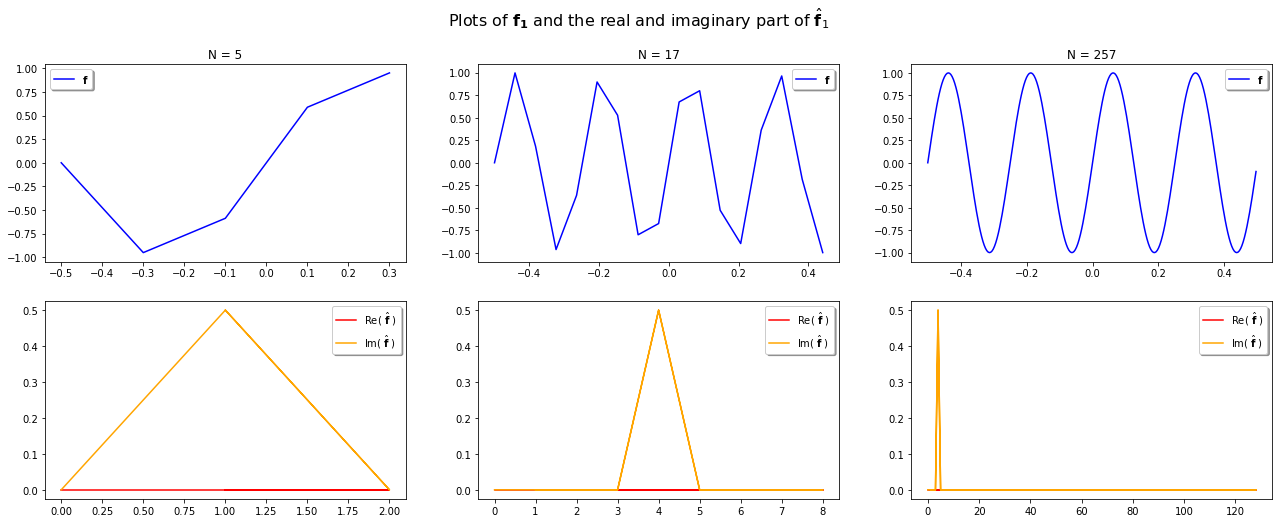

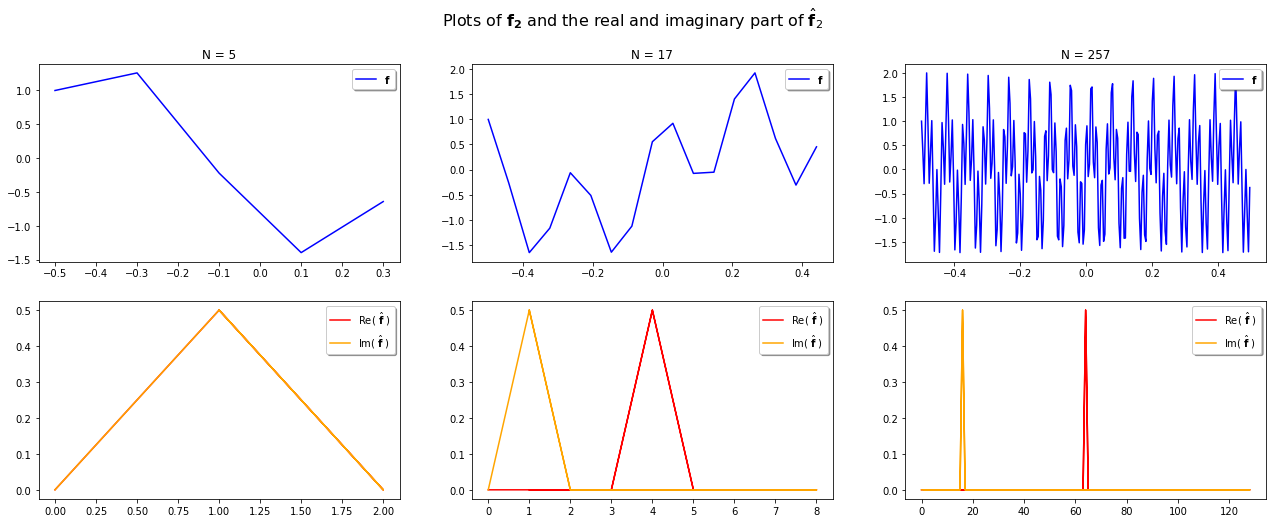

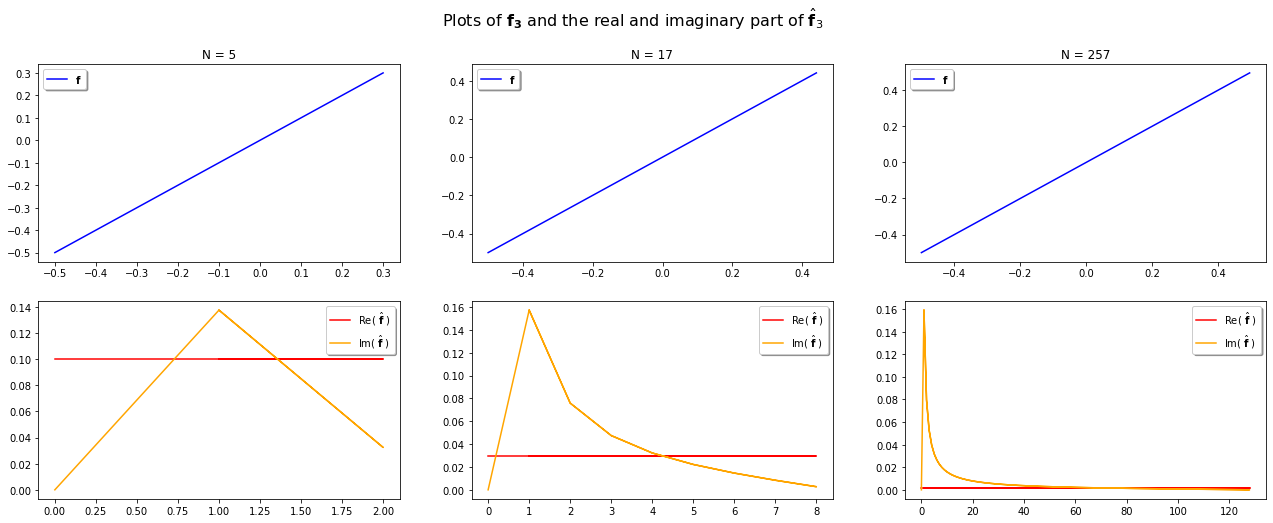

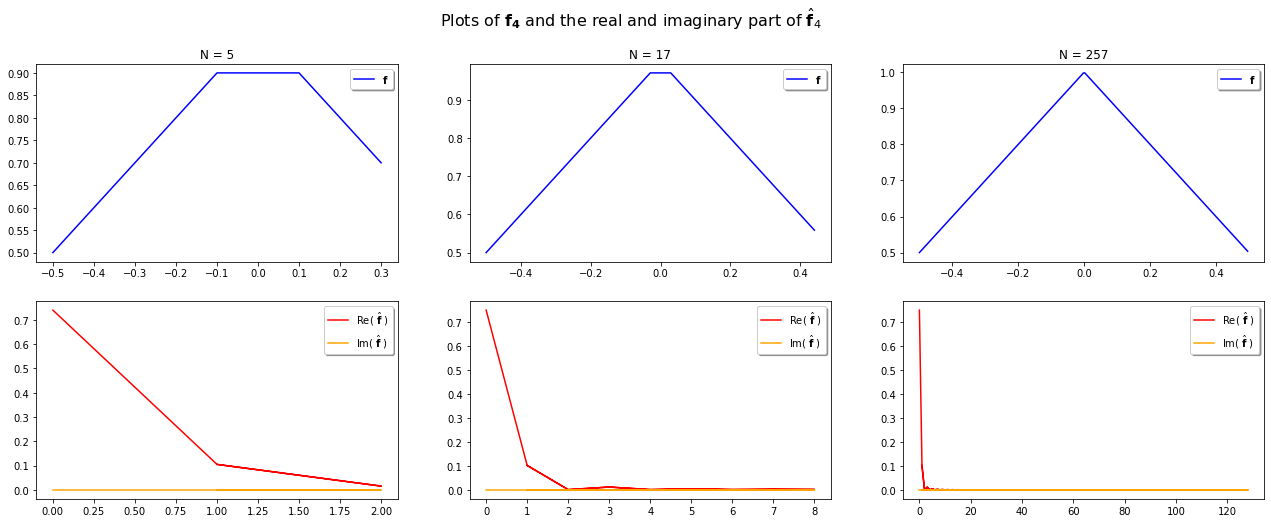

In [35]:
N = [5, 17, 257]
start = -1/2
functions = [f1, f2, f3, f4]
suptitles = [r'Plots of $\bf{f}_1$ and the real and imaginary part of $\hat{\bf{f}}_1$', r'Plots of $\bf{f}_2$ and the real and imaginary part of $\hat{\bf{f}}_2$',
             r'Plots of $\bf{f}_3$ and the real and imaginary part of $\hat{\bf{f}}_3$', r'Plots of $\bf{f}_4$ and the real and imaginary part of $\hat{\bf{f}}_4$']

for k in range(len(functions)):
    fig, ax = plt.subplots(2, 3, figsize = (22, 8))
    fig.suptitle(suptitles[k], fontsize = 16)
    for i in range(len(N)):
        f = functions[k]
        x = np.linspace(start, start + 1, N[i], endpoint=False)
        f_vals = f(x) 
        f_trans = transform(f, N[i], start)
        f_freq = abs(scipy.fft.fftfreq(N[i], 1/N[i]))
        plots = [f_vals, [abs(f_trans.real), abs(f_trans.imag)] ]
        titles = ["N = 5", "N = 17", "N = 257"]
        labels = [r'$\bf{f}$', r'Re( $\hat{\bf{f}}$ )', r'Im( $\hat{\bf{f}}$ )']
        colors = ["blue", "red", "orange"]
        ax[0, i].set_title(titles[i])
        for j in range(2):
            if len(plots[j]) == 2:
                ax[j, i].plot(f_freq, plots[j][0], label = labels[j], c = colors[j])
                ax[j, i].plot(f_freq, plots[j][1], label = labels[j+1], c = colors[j+1])
                ax[j, i].legend(shadow = True)
            else:
                ax[j, i].plot(x, plots[j], label = labels[j], c = colors[j])
                ax[j, i].legend(shadow = True)

    plt.show()

We observe that for every value of $N$, $\hat{\textbf{f}}$ approximates $f_3$ well. However, this is not the case for any of the other functions. For $f_1$, $f_2$ and $f_4$ only $N=257$ ensures that $\hat{\textbf{f}}$ is good approximation of $f$.

**1i)**

We will proceed to plot the discrete Fourier coefficients of $\hat{\textbf{f}}_2$ after applying "scipy.fft.ffttshift()" to the values generated from the transform() algorithm. The fftshift procedure moves every zero-frequency componenet to the center of the spectrum.

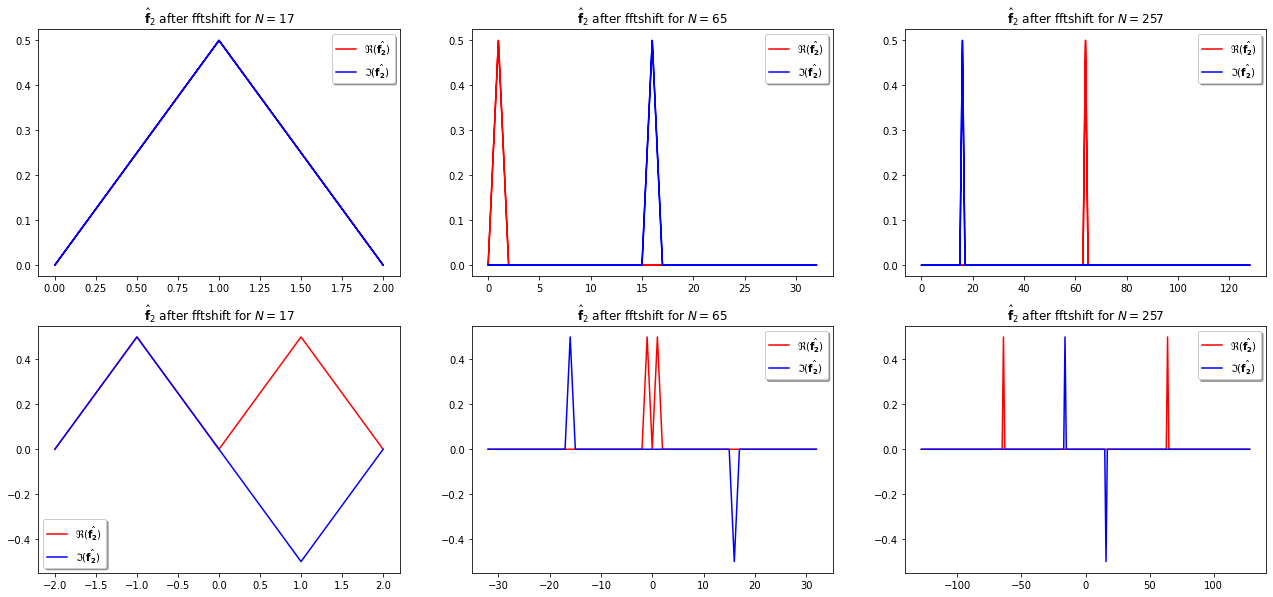

In [36]:
N = [5, 65, 257]
start_shift = -1/2
titles = [r'$\hat{\bf{f}}_2$ after fftshift for $N= 17$',
          r'$\hat{\bf{f}}_2$ after fftshift for $N= 65$', 
          r'$\hat{\bf{f}}_2$ after fftshift for $N= 257$']

fig, ax = plt.subplots(2, 3, figsize=(22, 10))
for i in range(len(N)):
    f2_trans = transform(f2, N[i], start)
    f2_freq = scipy.fft.fftshift(scipy.fft.fftfreq(N[i], 1/N[i]))
    f2_shift = scipy.fft.fftshift(f2_trans)
    ax[0, i].plot(abs(f2_freq), abs(f2_shift.real), label = r'$\Re (\hat{\bf{f}_2})$', c = "red")
    ax[0, i].plot(abs(f2_freq), abs(f2_shift.imag), label = r'$\Im (\hat{\bf{f}_2})$', c = "blue")
    ax[0, i].legend(shadow = True)
    ax[0, i].set_title(titles[i])
    ax[1, i].plot(f2_freq, f2_shift.real, label = r'$\Re (\hat{\bf{f}_2})$', c = "red")
    ax[1, i].plot(f2_freq, f2_shift.imag, label = r'$\Im (\hat{\bf{f}_2})$', c = "blue")
    ax[1, i].legend(shadow = True)
    ax[1, i].set_title(titles[i])

plt.show()

Considering $f_2(x) = \sin(32 \pi x) + \cos(128 \pi x)$, obtaining $a_k(f_2)$ and $b_k(f_2)$ is a straightforward task. 

\begin{align*}
f_2(x) = \frac{a_0}{2}+\sum_{k=1}^n a_k \cos (2 \pi k x)+b_k \sin (2 \pi k x) = \sin(32 \pi x) + \cos(128 \pi x) \Longleftrightarrow 
a_k(f_2) = \begin{cases} 1, & k = 64 \\ 0, & \text{else} \end{cases}, \quad b_k(f_2) = \begin{cases} 1, & k = 16 \\ 0, & \text{else} \end{cases} 
\end{align*}

Obtaing the complex fourier coefficients $c_k(f_2)$ can be done with the same approach.

\begin{align*}
f_2(x) &= \sum_{k=-n}^n c_k e^{2 \pi i k x} = \sin(32 \pi x) + \cos(128 \pi x) = \frac{e^{2 \pi i x \cdot 16} - e^{2 \pi i x \cdot (-16)}}{2i} + \frac{e^{2 \pi i x \cdot 64} + e^{2 \pi i x \cdot (-64)}}{2} \\
&= \frac{1}{2i} e^{2 \pi i x \cdot 16} - \frac{1}{2i} e^{2 \pi i x \cdot (-16)} + \frac{1}{2} e^{2 \pi i x \cdot 64} + \frac{1}{2} e^{2 \pi i x \cdot (-64)} = -\frac{i}{2} e^{2 \pi i x \cdot 16} + \frac{i}{2} e^{2 \pi i x \cdot (-16)} + \frac{1}{2} e^{2 \pi i x \cdot 64} + \frac{1}{2} e^{2 \pi i x \cdot (-64)}  \\
\end{align*}
$$
\Longleftrightarrow 
c_k(f_2) = \begin{cases} \frac{1}{2}, & k = \pm 64 \\ \pm \frac{i}{2}, & k = \mp 16 \\ 0, & \text{else} \end{cases}
$$

Looking carefully, we observe that the complex coefficients $c_k = \hat{\textbf{f}}_k$ for $N = 257$. If our goal is to remove the second summand of $f_2$, that is removing the cosine term, it is sufficient to set the real non-zero entries of $\hat{\textbf{f}}_k$ to zero. That is  $\hat{\textbf{f}}_{-64} = \hat{\textbf{f}}_{64} = c_{-64} = c_{64} = 0$. Hence, preforming the inverse fourier transform of the modified $\hat{\textbf{f}}$ will result in only the first summand of $f_2$. In the code block below we observe that this method works.

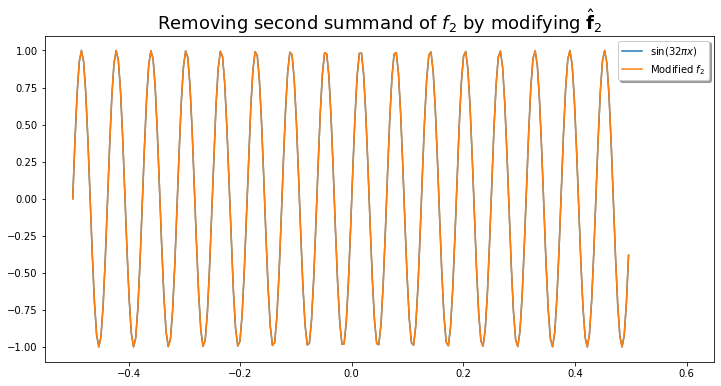

In [37]:
f_hat = transform(f2, N = 257, start = -1/2)
f_hat_mod = f_hat - f_hat.real
f_mod = scipy.fft.ifft(f_hat_mod, norm = 'forward')
X = np.linspace(-1/2, 1/2, len(f_mod), endpoint=False)

fig = plt.figure(figsize = (12, 6))
plt.title(r'Removing second summand of $f_2$ by modifying $\hat{\bf{f}}_2$', fontsize = 18)
plt.plot(X, np.sin(32 * np.pi * X), label = r'$\sin(32 \pi x)$')
plt.plot(X, f_mod, label = r'Modified $f_2$')
plt.legend(shadow=True, fancybox = True)
plt.xlim(-0.55 , 0.65)
plt.show()

The Nyquist-Shannon sampling theorem, states that for a signal that contains no frequencies higher than $N$, then the function is completly determined by a sample of the signal preformed with a rate of $\frac{1}{2 N}$. Therby, considering $f_2$, in the case where $N$ is significantly lower than $257$, e.g. $N = 17$, the $DFT$ no longer equals the fourier coefficients of the function. We are not testing for frequencies that represents the second summand in $f_2$. The periodic property of $\hat{\textbf{f}}_k$ actually makes sure that $\hat{\textbf{f}}_{64} = \hat{\textbf{f}}_{13} = 0$. We cannot alter this value since it represents other freqencies as well. Thus, the procedure described above will not be able to remove the cosine term of $f_2$.

### **Task 2**

**2a)**

We have been given that

\begin{align*}
    f(x) = \sum_{k \in \mathbb{Z}} c_k(f) e^{2 \pi i k x}
\end{align*}

converges absolutely and uniformly. Thus we have

\begin{align*}
    \hat f_k &= \frac{1}{N} \sum_{j = 0}^{N-1} f(x_j) e^{- 2 \pi i k x_j} \\
    &= \frac{1}{N} \sum_{j = 0}^{N-1} f \left(\frac{j}{N} \right) e^{- 2 \pi i k \frac{j}{N}} \\
    &= \frac{1}{N} \sum_{j = 0}^{N-1} \left( \sum_{n \in \mathbb{Z}} c_n(f) e^{2 \pi i n \frac{j}{N}} \right) e^{- 2 \pi i k \frac{j}{N}} \\
    &= \sum_{n \in \mathbb{Z}} c_n(f)  \left( \frac{1}{N} \sum_{j = 0}^{N-1} e^{2 \pi i n \frac{j}{N}} e^{- 2 \pi i k \frac{j}{N}} \right) \\
    &= \sum_{n \in \mathbb{Z}} c_n(f)  \left( \frac{1}{N} \sum_{j = 0}^{N-1} e^{2 \pi i (n - k) \frac{j}{N}} \right)
\end{align*}

As we have shown in **1f)**, the second parentheses is $1$ when $n - k \equiv 0 \space (\bmod \space N)$ and $0$ otherwise. We get:

\begin{align*}
    \hat f_k &= \sum_{n \in \mathbb{Z}} c_n(f)  \left( \frac{1}{N} \sum_{j = 0}^{N-1} e^{2 \pi i (n - k) \frac{j}{N}} \right) \\
    &= \sum_{{\substack{n \in \mathbb{Z} \\ n = k + aN}}} c_n(f)  \\
    &= \sum_{a \in \mathbb{Z}} c_{k + aN}(f)  \\
\end{align*}

$\square$

**2b)**

let $f$ be defined on the circle and its complex Fourier coefficients $c_k(f)$ be given. 

\begin{align*}
    c_k(\tau_N f) &\coloneqq \int_{-\frac{1}{2}}^{\frac{1}{2}} \tau_N f(x) e^{-2 \pi i k x} dx\\
    &= \int_{-\frac{1}{2}}^{\frac{1}{2}} f \left(x-\frac{1}{N} \right) e^{-2 \pi i k x} e^{-2 \pi i k \left(\frac{1}{N} - \frac{1}{N} \right)} dx\\
    &= e^{-2 \pi i \frac{k}{N}}\int_{-\frac{1}{2}}^{\frac{1}{2}} f \left(x-\frac{1}{N} \right) e^{-2 \pi i k \left(x - \frac{1}{N} \right) } dx\\
\end{align*}

Now let $u = x - \frac{1}{N}$ then $dx = du$. Also, $f$ is $1$-periodic, meaning integrating over any interval of length 1 gives the same value.


\begin{align*}
    &= e^{-2 \pi i \frac{k}{N}}\int_{-\frac{1}{2} + \frac{1}{N}}^{\frac{1}{2} + \frac{1}{N}} f \left(u \right) e^{-2 \pi i k \left(u\right) } du\\
    &= e^{-2 \pi i \frac{k}{N}} \int_{-\frac{1}{2}}^{\frac{1}{2}} f(x) e^{-2 \pi i k x} dx \\
    &= e^{- \frac{2 \pi i k}{N}} c_k(f). 
\end{align*}

Note that $c_k(\tau_N^s f) = e^{- \frac{2 \pi i k}{N}} c_k(\tau_N^{s -1} f)$. iterating all the way down gives the general relationship:


\begin{align*}
    c_k(\tau_N^s f) =  e^{- \frac{2 \pi i k s}{N}} c_k( f)
\end{align*}

$\square$

**2c)**

Consider $g(x) = \sum_{j = 0}^{N-1} a_j f(x - \frac{j}{N}) \in V_{N, f} = \text{span} \big(f, \tau_N f, \tau^2_{N}f, \ldots, \tau^{N-1}_N f\big)$. We will further show that the translation $\tau_N g$ is also an element of the vector space $V_{N, f}$.

\begin{align*}
\tau_Ng(x) = g(x - \frac{1}{N}) = \sum_{j = 0}^{N-1} a_j f(x - \frac{1 + j}{N}) = \sum_{j = 0}^{N-1} a_j \tau_N^{1 + j}f(x) = \sum_{j = 0}^{N-1} \tilde{a}_j \tau_N^{j}f(x)
\end{align*}

In the above equation $\tilde{a}_j = a_{(j - 1 \bmod N)}$ is the coefficients of $\tau_Ng$.
This is a linear combination of the elements $\tau_{N}^{k} f, k \in \{0, 1, \cdots, N-1\}$. Thus, it is clearly an element of $V_{N,f}$.


**2d)**

Assume $f$ is defined on the circle. Define now

\begin{align*}
    G = (\langle \tau_N^k f, \tau_N^j f \rangle)_{k,j = 0}^{N-1}
\end{align*}

Let's calculate any coordinate:

\begin{align*}
    \langle \tau_N^k f, \tau_N^j f \rangle = \int_0^1 f \left( x - \frac{k}{N} \right) \overline {f \left ( x - \frac{j}{N} \right)} dx \\
\end{align*}

Substitute $u = x - \frac{j}{N}$ Then

\begin{align*}
    \int_{-\frac{j}{N}}^{1 - \frac{j}{N}} f \left( u +\frac{j}{N} - \frac{k}{N} \right) \overline {f \left ( u \right)} du \\
    \int_{-\frac{j}{N}}^{1 - \frac{j}{N}} f \left( u - \frac{k - j}{N} \right) \overline {f \left ( u \right)} du \\
\end{align*}

Also, $f$ is $1$-periodic, meaning integrating over any interval of length $1$ gives the same answer. 

\begin{align*}
    \int_0^1 f \left( u - \frac{k - j}{N} \right) \overline {f \left ( u \right)} du \\
\end{align*}

We claim now that the $1$-periodic property also makes sure that if $k_1 - j_1 \equiv k_2 - j_2 \space (\bmod\space N)$ then $\langle \tau_N^{k_i} f, \tau_N^{j_i} f \rangle$ yields the same value for $i =1,2$. Assume $a \in \mathbb{Z}$

\begin{align*}
    f \left( u - \frac{k_1 - j_1}{N} \right) &= f \left( u - \frac{k_2 - j_2 + aN}{N} \right)\\ 
    &= f \left( u - \frac{k_2 - j_2}{N} + a\right) \\
     &= f \left( u - \frac{k_2 - j_2}{N}\right)
\end{align*}

For the matrix to be circulant, it need to be

\begin{align*}
    \left ( a_{k - l \space (\bmod \space N)}\right )_{k,l = 0}^{N-1}
\end{align*}

Define now
\begin{align*}
    a_{i} =  \int_0^1 f \left( u - \frac{i}{N} \right) \overline {f \left ( u \right)} du 
\end{align*}

We now, by construction:
\begin{align*}
(\langle \tau_N^k f, \tau_N^j f \rangle)_{k,j = 0}^{N-1} = (a_{k-j \space (\bmod \space N)})_{k,j = 0}^{N-1}
\end{align*}
 
Which is the circulant matrix of $a_i$ (up to the $N$-th index), proving $G$ circulant. 

$\square$

Also by construction, (and Parsevals identity)

\begin{align*}
    a_j &= \langle \tau_N^j f, f\rangle \\
    &= \sum_{k \in \mathbb{Z}} c_k(\tau_N^j f) \overline{c_k(f)} \\
    &= \sum_{k \in \mathbb{Z}} e^{- 2 \pi i k \frac{j}{N}}c_k( f) \overline{c_k(f)} \\
    &= \sum_{k \in \mathbb{Z}} e^{- 2 \pi i k \frac{j}{N}}|c_k( f)|^2 \\
    \implies \hat{a}_l &= \frac{1}{N}\sum_{j=0}^{N-1} a_j e^{-2\pi i l \frac{j}{N}} \\
    &= \frac{1}{N}\sum_{j=0}^{N-1} \left( \sum_{k \in \mathbb{Z}} e^{- 2 \pi i k \frac{j}{N}}|c_k( f)|^2 \right) e^{-2\pi i l \frac{j}{N}} \\
    &= \sum_{k \in \mathbb{Z}} |c_k( f)|^2 \frac{1}{N}\sum_{j=0}^{N-1} e^{- 2 \pi i (k+l) \frac{j}{N}} \\
    &= \sum_{\substack{k \in \mathbb{Z} \\ k + l \equiv 0 \space( mod \space N)}} |c_k( f)|^2\\
    &= \sum_{a \in \mathbb{Z}} |c_{aN - l}( f)|^2\\
\end{align*}

This are the entries of the diagonal matrix $\text{diag}(\hat{a})$. Now since it is a diagonalization, these values are eigenvalues of $\text{circ}(a)$ (divided by $N$ but that is nonimportant).

***Claim:*** The condition
\begin{align*}
    \sum_{a \in \mathbb{Z}} |c_{h + aN}( f)|^2 \neq 0 \quad \forall h
\end{align*}

makes $\tau_N^i f$ linear independent. 

***Proof:***

We have seen that $\hat a_l = \sum_{a \in \mathbb{Z}} |c_{aN - l}( f)|^2$ are a multiplum og eigenvalues of $\text{circ}(a)$. If these are nonzero, $G = \text{circ}(a)$ is invertible. In other words, has full rank. 

Now assume ${\tau_N^i f}_{i=0}^{N-1}$ to be linear dependent. That is, for some $j$, we have

\begin{align*}
    \tau_N^j f = \sum_{\substack{l = 0 \\ l \neq j }}^{N-1} \alpha_l \tau_N^l f
\end{align*}

applying the translation once more shows that

\begin{align*}
    \tau_N^{j+1} f = \sum_{\substack{l = 0 \\ l \neq j }}^{N-1} \alpha_l \tau_N^{l+1} f
\end{align*}

Call this property (1). Apply now innerproduct $\langle \cdot, f\rangle$ on both sides

\begin{align*}
    a_j &= \langle \tau_N^{j} f , f\rangle \\
    &= \left \langle \sum_{\substack{l = 0 \\ l \neq j }}^{N-1} \alpha_l \tau_N^{l} f, f \right \rangle \\
    &= \sum_{\substack{l = 0 \\ l \neq j }}^{N-1} \alpha_l \left \langle \tau_N^{l} f, f \right \rangle \\
    &= \sum_{\substack{l = 0 \\ l \neq j }}^{N-1} \alpha_l a_l \\
\end{align*}

By the same argument, and property (1), we have:

\begin{align*}
    a_{j+1} &= \langle \tau_N^{j+1} f , f\rangle \\
    &= \left \langle \sum_{\substack{l = 0 \\ l \neq j }}^{N-1} \alpha_l \tau_N^{l+1} f, f \right \rangle \\
    &= \sum_{\substack{l = 0 \\ l \neq j }}^{N-1} \alpha_l \left \langle \tau_N^{l+1} f, f \right \rangle \\
    &= \sum_{\substack{l = 0 \\ l \neq j }}^{N-1} \alpha_l a_{l+1} \\
\end{align*}

Thus, we have

$$
\begin{bmatrix}
a_j \\
\vdots \\
a_{j-1}
\end{bmatrix} = 
\sum_{\substack{l = 0 \\ l \neq j }}^{N-1} \alpha_l \begin{bmatrix}
a_l \\
\vdots \\
a_{l-1} \end{bmatrix}
$$

A column is linear dependent on the other, meaning the matrix has not full rank. This is a contradiction, Our assuption is wrong. ${\tau_N^i f}_{i=0}^{N-1}$ is linear independent. 

$\square$

When the translates are orthonormal, $circ(a)$ is obviously the identity. We have $a_i = \delta_{0,i} $ and therefore

\begin{align*}
    \hat{a}_l &= \frac{1}{N}\sum_{j=0}^{N-1} a_j e^{-2\pi i l \frac{j}{N}} \\
    &= \frac{1}{N}\sum_{j=0}^{N-1} \delta_{0,i} e^{-2\pi i l \frac{j}{N}} \\
    &= \frac{1}{N} =
    \sum_{a \in \mathbb{Z}} |c_{aN - l}( f)|^2
\end{align*}

This condition is sufficient when the translates are orthonormal

\begin{align*}
    \sum_{a \in \mathbb{Z}} |c_{aN - l}( f)|^2 = \frac{1}{N}
\end{align*}

**2e)**

Consider an element $g \in V_{N, f}$, be defined by the coefficients $\textbf{a} = (a_0, a_1, \ldots, a_{N-1}) \in \mathbb{R}^N$. Moreover, denote the $DFT$ $\hat{\textbf{a}} = (\hat{a}_0, \hat{a}_1, \ldots, \hat{a}_{N-1})$.Further, we introduce $k \in \mathbb{Z}$, as the decompoisition $k = h + Nz, h \in \mathbb{Z}_N \wedge z \in \mathbb{Z}$

***Claim:*** $g \in V_{N,f} \Longleftrightarrow c_k(g)=\left( \sum_{j=0}^{N-1} a_j \mathrm{e}^{-2 \pi \mathrm{i} k j / N}\right) c_k(f)=N\hat{a}_h c_k(f)$

Lets first consider $g \in V_{N,f} \implies c_k(g)=\left( \sum_{j=0}^{N-1} a_j \mathrm{e}^{-2 \pi \mathrm{i} k j / N}\right) c_k(f)=N\hat{a}_h c_k(f)$

\begin{align*}
c_k(g) = \langle g, e^{2 \pi i k \cdot} \rangle &=  \langle \sum_{j = 0}^{N-1} a_j \tau_{N}^j f , e^{2 \pi i k \cdot} \rangle \\
                                                &=  \sum_{j = 0}^{N-1} a_j \langle \tau_{N}^j f , e^{2 \pi i k \cdot} \rangle \\
                                                &=  \sum_{j = 0}^{N-1} a_j c_k(\tau_{N}^j f) \\
                                                &=  \sum_{j = 0}^{N-1} a_j e^{-2 \pi i k j/N}c_k(f) \\ 
                                                &=  \sum_{j = 0}^{N-1} a_j e^{-2 \pi i (h + Nz) j/N}c_k(f)  \\
                                                &=  \sum_{j = 0}^{N-1} a_j (e^{-2 \pi i h j/N} e^{-2 \pi i Nz j/N})c_k(f) \\
                                                &=  \sum_{j = 0}^{N-1} a_j e^{-2 \pi i h j/N}c_k(f) \\
                                                &=  \big(\sum_{j = 0}^{N-1} a_j e^{-2 \pi i h j/N}\big) c_k(f) = N \hat{a}_h c_k(f)
\end{align*}

The fifth equality is derived directly from task **2b)**.

Seeking to prove the converse, we begin by the following. Assume $g$ and $f$ to be continous functions defined on the circle

\begin{align*}
c_k(g) = N \hat{a}_hc_k(f) \implies \langle g, e^{2 \pi i k \cdot} \rangle = \langle \sum_{j = 0}^{N-1} a_j \tau_{N}^j f , e^{2 \pi i k \cdot} \rangle \implies 
\langle g - \sum_{j = 0}^{N-1} a_j \tau_{N}^j f , e^{2 \pi i k \cdot} \rangle = 0
\end{align*}

Define the function $\Xi: \mathbb{T} \rightarrow \mathbb{C}$, as $\Xi \triangleq g - \sum_{j = 0}^{N-1} a_j \tau_{N}^j f$. It follows from the above derivation, that the Fourier coefficients, $c_k(\Xi) = 0, \forall k \in \Z$. Applying Parsaval's identity we proceed

\begin{align*}
\| \Xi \|_{L^2(-\frac{1}{2}, \frac{1}{2})}^2 = \sum_{k \in \mathbb{Z}} |c_k(\Xi)|^2 = 0
\end{align*}

The norm is positive definite for continous functions, i.e. $\| \Xi \|_{L^2(-\frac{1}{2}, \frac{1}{2})}^2 = 0 \implies \Xi = 0$. Therby, we conclude $g = \sum_{j = 0}^{N-1} a_j \tau_{N}^j f \implies g \in V_{N, f}.$

$\square$


**2f)**

Define the fundamental interpolant to be

\begin{align*}
    I_N(x_j) =\left\{\begin{array}{ll}
1 & \text { if } j = 0, \\
0 & \text { else },\end{array} \right.
\end{align*}


By the defintion of the discrete Fourier transform we get,

\begin{align*}
    \hat{f_k} &= \frac{1}{N} \sum_{j = 0}^{N-1} f(x_j) e^{- 2 \pi i k \frac{j}{N}} \\
    \widehat{\left( I_N\right)_k} &= \frac{1}{N} \sum_{j = 0}^{N-1} I_N(x_j) e^{- 2 \pi i k \frac{j}{N}} \\
    &= \frac{1}{N} \\
\end{align*}

Assume now $I_N \in V_{N,f}$. Then there exists $\hat a_k$ such that 

\begin{align*}
    c_k(I_N) = N \hat a_k c_k(f)
\end{align*}

Necessarily for the index $k = h + Nz$. Thus

\begin{align*}
    c_{h + Nz}(I_N) = N \hat a_{h + N z} c_{h + N z}(f)
\end{align*}

Finally, by the aliasing formula

\begin{align*}
    \frac{1}{N} = \widehat{\left( I_N\right)_k} = \sum_{z \in \mathbb{Z}} c_{k + zN}(I_N) = \sum_{z \in \mathbb{Z}} N \hat a_{h + N z} c_{h + N z}(f) = N \hat a_{h} \sum_{z \in \mathbb{Z}}  c_{h + N z}(f)
\end{align*}

proving $\sum_{z \in \mathbb{Z}}  c_{h + N z}(f) \neq 0$

Assume now that $\sum_{z \in \mathbb{Z}}  c_{h + N z}(f) \neq 0$

We can now define the function

\begin{align*}
    \phi(x) = \frac{1}{N} \sum_{l \in \mathbb{Z}} \frac{c_l(f)}{\hat{f}_l} e^{2 \pi i l x}
\end{align*}

By the aliasing formula, $\hat{f}_l \neq 0 \space \forall l$, so $\phi$ is well defined. 

It's fourier coefficients will be

\begin{align*}
    c_k(\phi) &= \int_0^1 \left ( \frac{1}{N} \sum_{l \in \mathbb{Z}} \frac{c_l(f)}{\hat{f}_l} e^{2 \pi i l x}\right) e^{- \pi i k x} dx \\
    &= \frac{1}{N} \sum_{l \in \mathbb{Z}} \frac{c_l(f)}{\hat{f}_l} \int_0^1 e^{2 \pi i (l-k) x}dx \\
    &= \frac{1}{N} \left ( \frac{c_k(f)}{\hat{f}_k} \int_0^1 e^{2 \pi i (l-k) x}dx + \sum_{\substack{l \in \mathbb{Z} \\ l \neq k}} \frac{c_l(f)}{\hat{f}_l} \int_0^1 e^{2 \pi i (l-k) x}dx \right )\\
    &= \frac{1}{N} \left ( \frac{c_k(f)}{\hat{f}_k} \int_0^1 dx + \sum_{\substack{l \in \mathbb{Z} \\ l \neq k}} \frac{c_l(f)}{\hat{f}_l}  \frac{1}{2 \pi i (j - k)} \left. e^{2 \pi i (j-k) x} \right |_0^1 \right )\\
    &= \frac{1}{N} \left ( \frac{c_k(f)}{\hat{f}_k} \int_0^1 dx + \sum_{\substack{l \in \mathbb{Z} \\ l \neq k}} \frac{c_l(f)}{\hat{f}_l}  \frac{1}{2 \pi i (j - k)} (1-1) \right )\\
    &= \frac{c_k(f)}{N\hat{f}_k}\\
\end{align*}

So by **2e)**, $\phi$ is in $V_{N,f}$. This also means that $N\hat{a}_h = \frac{1}{N \hat{f_k}}$ We will use this later. 

Moreover,

\begin{align*}
    \hat{\phi}_k &= \frac{1}{N} \sum_{j = 0}^{N-1} \left( \frac{1}{N} \sum_{l \in \mathbb{Z}} \frac{c_l(f)}{\hat{f}_l} e^{2 \pi i l x_j} \right) e^{- 2 \pi i k x_j}\\
    &= \frac{1}{N} \sum_{l \in \mathbb{Z}} \frac{c_l(f)}{\hat{f}_l} \left ( \frac{1}{N}  \sum_{j = 0}^{N-1} e^{2 \pi i (l-k) x_j} \right )  \\
\end{align*}

The last parenthesis is $1$ when $l-k \equiv 0 \space (mod \space N)$ (or necessarily $l = k + aN, a \in \mathbb{Z}$) and $0$ else. 

We now get

\begin{align*}
    \hat{\phi}_k &=\frac{1}{N} \sum_{\substack{l \in \mathbb{Z}}\\ l = k + aN} \frac{c_l(f)}{\hat{f}_l}  \\
    &=\frac{1}{N} \sum_{a \in \mathbb{Z}} \frac{c_{k + aN}(f)}{\hat{f}_{k + aN}}  \\
\end{align*}

Furthermore, $\hat{f}_k = \hat{f}_{k + N}$. 

\begin{align*}
    \hat{\phi}_k &=\frac{1}{N} \sum_{a \in \mathbb{Z}} \frac{c_{k + aN}(f)}{\hat{f}_{k + aN}}  \\
    &=\frac{1}{N} \sum_{a \in \mathbb{Z}} \frac{c_{k + aN}(f)}{\hat{f}_{k}}  \\
    &=\frac{1}{N} \frac{1}{\hat{f}_{k}}\sum_{a \in \mathbb{Z}} c_{k + aN}(f)  \\
    &=\frac{1}{N} \frac{\hat{f}_{k}}{\hat{f}_{k}}  \\
    &= \frac{1}{N}
\end{align*}

This holds for all $k$. Finally

\begin{align*}
    \frac{1}{N} = \hat{\phi}_k &= \frac{1}{N} \sum_{j = 0}^{N-1} \phi(x_j) e^{- 2 \pi i k x_j} \\
    \implies 1 &= \sum_{j = 0}^{N-1} \phi(x_j) e^{- 2 \pi i k x_j} \quad\forall k
\end{align*}

Which can be written as a matrix system. $\vec{\phi} = (\phi(x_0), \phi(x_1), ..., \phi(x_{N-1}))^T$ and $\vec{1} = (1,1,...,1)^T$

\begin{align*}
    N\mathcal{F}_N \vec{\phi} &= \vec{1} \\
    \vec{\phi} &= \overline{\mathcal{F}_N} \vec{1} \\
    &= \begin{bmatrix} \frac{1}{N} \sum_{j = 0}^{N - 1} e^{2 \pi i 0 \frac{j}{N}} \\ \frac{1}{N} \sum_{j = 0}^{N - 1} e^{2 \pi i 1 \frac{j}{N}} \\ \vdots \\ \frac{1}{N} \sum_{j = 0}^{N - 1} e^{2 \pi i (N - 1) \frac{j}{N}}  \end{bmatrix} \\
    &= \begin{bmatrix} 1 \\ 0 \\ \vdots \\ 0  \end{bmatrix} \\
\end{align*}

Proving $\phi$ to be the fundamental interpolant, which we have seen is in $V_{N,f}$

We will not prove this, but the fundamental interpolant is unique if it exist.

$\square$

**2g)**

We assume that the fundamental interpolant is in $V_{N,f}$. From **2e)** we know that $\sum_{a \in \mathbb{Z}} c_{k+aN}(f) \neq 0$. 

Now a function which interpolates $g$ is given by

\begin{align*}
    \tilde{g}(x) = \sum_{j = 0}^{N-1} s_j \tau_N^j I_N(x)
\end{align*}

Which must be in $V_{N,f}$. Note that $\hat{g}_h = \hat{\tilde g}_h$ since they take the same value in all $\frac{j}{N}$


since $\tilde g \in V_{N, f}$, that is, there exists some $\hat{a}_h$ such that $c_k(\tilde g) = N a_h c_k(f)$. Now

\begin{align*}
    \hat{g}_h &= \hat{\tilde g}_h \\
    &= \sum_{z \in \mathbb{Z}} c_{h+zN}(\tilde g) \\
    &= \sum_{z \in \mathbb{Z}} N \hat{a}_h  c_{h+zN}(f) \\
    &= N \hat{a}_h \sum_{z \in \mathbb{Z}}  c_{h+zN}(f) \\
    &= N \hat{a}_h \hat{f}_h \\
    \implies \hat{a}_h &= \frac{\hat{g}_h}{N\hat{f}_h}
\end{align*}

Where we have used that $\hat{f}_k \neq 0$. Using the inverse fourier matrix one can easily obtain the coefficients $a_j$. 



We can now proceed to implement an algorithm for periodic interpolation, derived from the discussion above.

In [38]:
def interpolate(s, ckf):
    '''
    input:
        s: samples
        ckf: fourier coefficients of the function f defining the space V_{N, f}
    output:
        a: coefficients defining the function in V_{N, f} that interpolate s 
    '''
    
    N = len(s)  # Length of samples array

    g_l = 1/N * np.fft.fft(s)   # Finding \hat{g}_l
    
    # Obtaing \hat{f}_l
    f_l = np.zeros( N )

    for k in range( N ):
        f_l[k] = np.sum( ckf[k::N] )
    
    a_h = g_l/f_l   # Obtaing DFT of a

    a = np.fft.ifft(a_h)
    a[1::2] *= -1 # Correcting factor
    return a

<a id='2g'></a>
[Test of interpolate function can be found here.](#test)

### **Task 3**

**3a)**

The dirichlet kernel is defined as such

\begin{align*}
    D_n(x) = \frac{1}{2n + 1} \sum_{k = -n}^{n} e^{2 \pi i k x}
\end{align*}

The Fourier coefficients is defined as

\begin{align*}
    c_k(D_n) &= \int_0^1 \frac{1}{2n + 1} \sum_{j = -n}^{n} e^{2 \pi i j x} e^{- 2 \pi i k x} dx \\
    &= \frac{1}{2n + 1} \int_0^1  \sum_{j = -n}^{n} e^{2 \pi i (j-k) x}  dx\\
    &= \frac{1}{2n + 1} \sum_{j = -n}^{n} \int_0^1   e^{2 \pi i (j-k) x} dx\\
\end{align*}

Assume $ -n \leq k \leq n$
\begin{align*}
    c_k(D_n)&= \frac{1}{2n + 1} \left ( 1 + \sum_{\substack{j = -n \\ j \neq k}}^n \int_0^1   e^{2 \pi i (j-k) x} \right)\\
    &= \frac{1}{2n + 1} \left ( 1 + \sum_{\substack{j = -n \\ j \neq k}}^n \left. \frac{1}{2 \pi i (j - k)} e^{2 \pi i (j-k) x} \right |_0^1 \right) \\
    &= \frac{1}{2n + 1} \left ( 1 + \sum_{\substack{j = -n \\ j \neq k}}^n \frac{1}{2 \pi i (j - k)} (1-1) \right)\\
    &= \frac{1}{2n + 1} \left ( 1 + \sum_{\substack{j = -n \\ j \neq k}}^n 0 \right)\\
    &= \frac{1}{2n + 1}
\end{align*}

Assume now $|k| > n$

\begin{align*}
    c_k(D_n)&= \frac{1}{2n + 1} \left ( \sum_{j = -n }^n \int_0^1   e^{2 \pi i (j-k) x} \right)\\
    &= \frac{1}{2n + 1} \left (\sum_{j = -n}^n \left. \frac{1}{2 \pi i (j - k)} e^{2 \pi i (j-k) x} \right |_0^1 \right) \\
    &= \frac{1}{2n + 1} \left ( \sum_{j = -n}^n \frac{1}{2 \pi i (j - k)} (1-1) \right)\\
    &= \frac{1}{2n + 1} \left (\sum_{j = -n}^n 0 \right)\\
    &= 0
\end{align*}

That is,

\begin{align*}
    c_k(D_n) =\left\{\begin{array}{ll}
\frac{1}{2n + 1} & \text { if } |k| \leq n, \\
0 & \text { else },\end{array} \right.
\end{align*}

Now, since $N = 2n + 1$, we have

\begin{align*}
    (\hat{D_n})_k = \sum_{a \in \mathbb{Z}} c_{h + a (2n+1)}(D_n) = c_h(D_n)
\end{align*}

Denote now $\psi$, the fundamental interpolation, defined by

\begin{align*}
    c_k(\psi(x)) = \frac{c_k(D_n)}{(2n +1) \hat{(D_n)}_k}
\end{align*}

from **2f)**, we have seen that this function must be the fundamental interpolant. 

\begin{align*}
    c_k(\psi(x)) &= \frac{c_k(D_n)}{(2n +1) \hat{(D_n)}_k} \\
    &= \frac{c_k(D_n)}{(2n +1) c_h(D_n)} \\
    &= \frac{c_k(D_n)}{(2n +1) \frac{1}{2n+1}} \\
    &= c_k(D_n)
\end{align*}

Which proves that the $D_n$ is the fundamental interpolant in $V_{2n+1, D_n}$(!). (It obviously exists in $V_{2n+1, D_n}$)

Further, we visualise the Dirichlet Kernel $D_n = \psi$

In [39]:
@jit(nopython = True, fastmath = True)
def exp_sum(n, x):
    '''
    input:
        n: bounds of summation
        x: value used in summation
    output:
        return f(x) = \sum_{k = -n}^{n+1} e^{2 \pi i k x} evaluated in x
    '''
    return np.sum( np.array( [np.exp(2 * np.pi * 1j * x *k) for k in range(-n, n+1)] )  )

def D(n, X, list = True):
    '''
    input:
        n: order of Dirichlet kernel
        X: x values
        list: if x is an array, default True
    output:
        Dirichlet kernel of order n, evaluated at every x in X
    '''
    if list == False:
        return 1 / (2 * n + 1) * exp_sum(n, X)

    return 1 / (2 * n + 1) * np.array( [exp_sum(n, x) for x in X] )

In [40]:
n_x = 10000
N = np.array( [5, 10, 17] )
X = np.linspace(0, 1, n_x)

D_arr = np.array( [D(n, X) for n in N] )

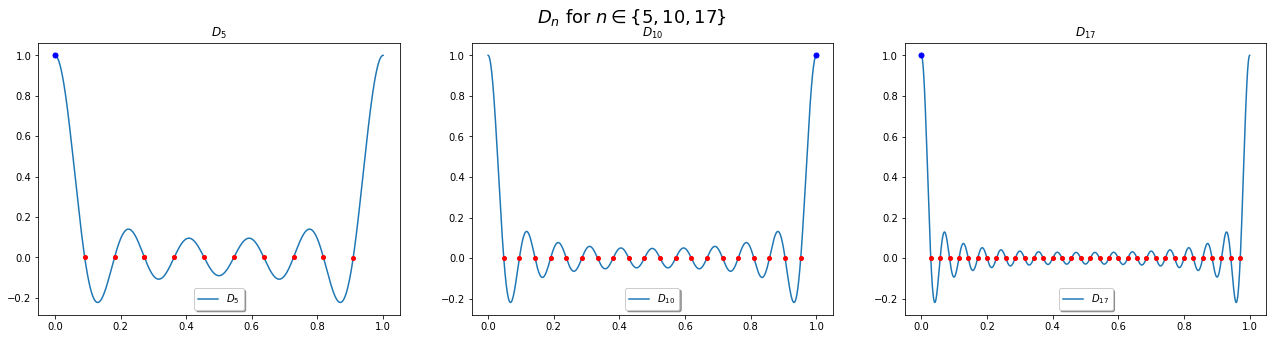

In [41]:
fig, ax = plt.subplots(1, 3, figsize = (22, 5))
lables = np.array( [r'$D_{5}$', r'$D_{10}$', r'$D_{17}$'] )

fig.suptitle(r'$D_{n}$ for $n \in \{5, 10, 17\}$', fontsize = 18)


for j in range(3):
    zeros_idx = np.argwhere( np.diff( np.sign(D_arr[j]) ) ).flatten()
    max_idx = np.argmax(D_arr[j])

    ax[j].plot(X, D_arr[j].real, label = lables[j])
    ax[j].title.set_text(r'$D_{%d}$'%N[j])
    ax[j].plot(X[max_idx], D_arr[j][max_idx].real, marker = '.', c = 'b', markersize = 10)
    for idx in zeros_idx:
        ax[j].plot(X[idx], D_arr[j].real[idx], 'r.', markersize = 8)
    ax[j].legend(shadow = True)
plt.show()

<a id='test'></a>
**Test of function from 2g)**

In [42]:
n = 5
s = np.zeros(2*n)
s[0] = 1
ckf = np.ones(2*n + 1) * 1/(2 * n + 1)

a = interpolate(s, ckf)

In [43]:
def construct_from_coeff(a, n, N):
    '''
    input:
        a: array of coefficients
        n: order of dirichlet kernel
        N: sice of space V_{N, D_n}
    return:
        lambda function g, such that g(x) = \sum_{j = 0}^{N-1} a_j D_n(x - j/N)
    '''
    return lambda x: np.sum( a[j]*D(n, x - j/N) for j in range(N) )

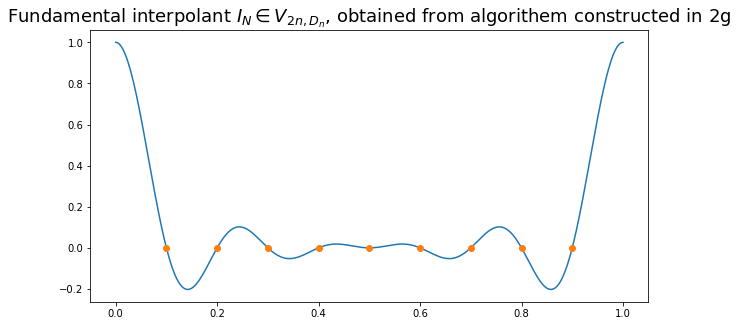

In [44]:
x = np.linspace(0,1, 1000)

g = construct_from_coeff(a, n, 2*n)
gvals = g(x)

fig = plt.figure(figsize = (10, 5))
plt.title(r'Fundamental interpolant $I_N \in V_{2n, D_n}$, obtained from algorithem constructed in 2g', fontsize = 18)
plt.plot(x, gvals.real)
plt.plot(np.linspace(0,1,2*n ,endpoint=False)[1:], np.zeros(2*n)[1:], 'o')
plt.show()

[Return to 2g](#2g) 

**3b)**

We need some convenient results before we can move on. If we are working in $V_{2n, D_n}$

\begin{align*}
    \hat{(D_n)}_k = \sum_{a \in \mathbb{Z}} c_{k + 2na}(D_n) =\left\{\begin{array}{ll}
c_k(D_n) & \text { if } |k| \leq n, \\
c_{-n}(D_n) + c_{n}(D_n) & \text{ if } |k| = n ,\end{array} \right. \quad -n \leq k \leq n
\end{align*}

We have seen that the fundmental interpolant is given by

\begin{align*}
    I_{2n}(x) = \frac{1}{2n} \sum_{l \in \mathbb{Z}} \frac{c_l(D_n)}{\hat{(D_n)}_l} e^{2 \pi i l x} \\
\end{align*}

Now $c_l(D_n) = 0$ for $ |l| > n$


\begin{align*}
    I_{2n}(x) &= \frac{1}{2n} \sum_{l \in \mathbb{Z}} \frac{c_l(D_n)}{\hat{(D_n)}_k} e^{2 \pi i l x} \\
    &= \frac{1}{2n} \sum_{l = - n}^{n} \frac{c_l(D_n)}{\hat{(D_n)}_k} e^{2 \pi i l x} \\
    &= \frac{1}{2n} \left( \sum_{|l| \leq  n -1} \frac{c_l(D_n)}{\hat{(D_n)}_k} e^{2 \pi i l x}  + \frac{c_{-n}(D_n)}{c_{-n}(D_n) + c_{n}(D_n)} e^{-2 \pi i n x} + \frac{c_n(D_n)}{c_{-n}(D_n) + c_{n}(D_n)} e^{2 \pi i n x} \right) \\
    &= \frac{1}{2n} \left( \sum_{|l| \leq  n-1} e^{2 \pi i l x}  + \frac{\frac{1}{2n+1}}{\frac{1}{2n+1} + \frac{1}{2n+1}} e^{-2 \pi i n x} + \frac{\frac{1}{2n+1}}{\frac{1}{2n+1} + \frac{1}{2n+1}} e^{2 \pi i n x} \right) \\
    &= \frac{1}{2n} \left( \sum_{|l| \leq  n-1} e^{2 \pi i l x}  + \frac{1}{2} ( e^{-2 \pi i n x} +  e^{2 \pi i n x}) \right) \\
    &= \frac{1}{2n} \left( \sum_{|l| \leq  n-1} e^{2 \pi i l x}  + \cos(2 \pi n x) \right) \\
    &= \frac{1}{2n} \left( (2n - 1) D_{n-1}(x)  + \cos(2 \pi n x) \right) 
\end{align*}

In [45]:
def interpolant(n, X, list = True):
    '''
    input:
        n: order of Dirichlet kernel
        X: x values
    output:
        Fundamental interpolant in space V_{2n, D_n}
    '''
    return 1/(2 * n) * ( (2*n - 1) * D(n - 1, X, list) + np.cos(2 * np.pi * n * X) )

In [46]:
n_x = 10000
N = np.array( [5, 10, 17] )
X = np.linspace(0, 1, n_x)

D_arr = np.array( [D(n, X) for n in N] )
Interpolat_arr = np.array( [interpolant(n, X) for n in N] )

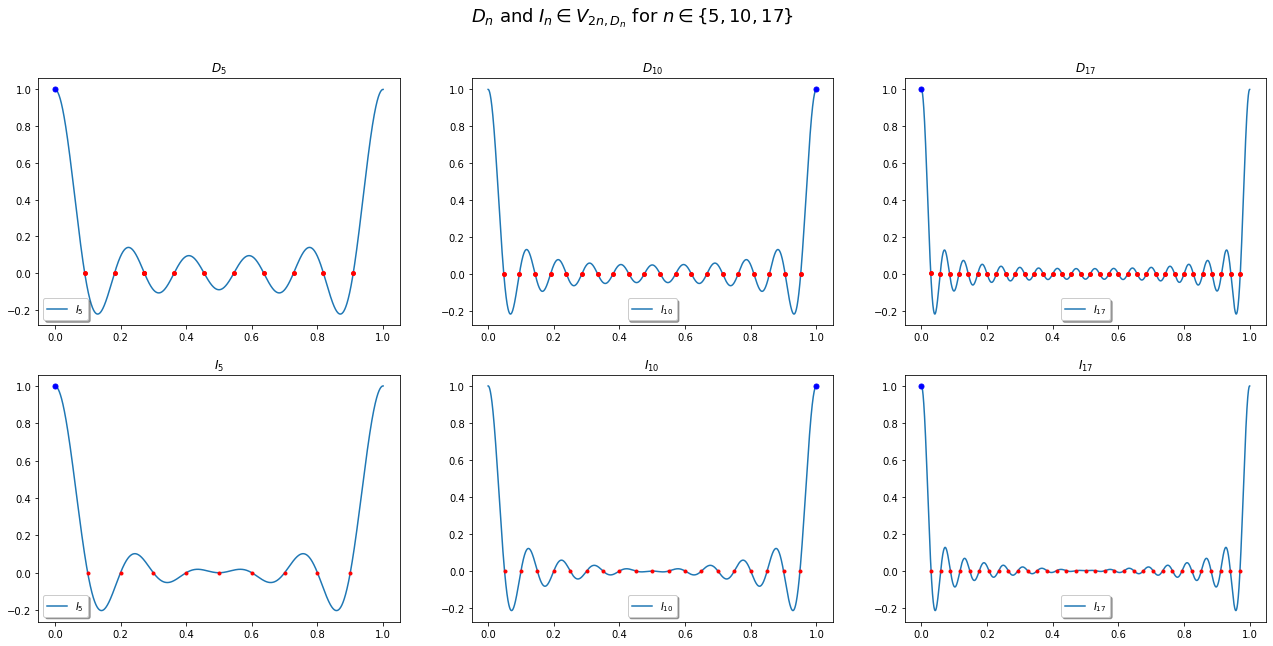

In [47]:
fig, ax = plt.subplots(2, 3, figsize = (22, 10))
lables_Dn = np.array( [r'$D_{5}$', r'$D_{10}$', r'$D_{17}$'] )
lables_inter = np.array( [r'$I_{5}$', r'$I_{10}$', r'$I_{17}$'] )

fig.suptitle(r'$D_n$ and $I_n \in V_{2n, D_n}$ for $n \in \{5, 10, 17\}$', fontsize = 18)

for j in range(3):
    zeros_idx = np.argwhere( np.diff( np.sign(D_arr[j]) ) ).flatten()   
    max_idx = np.argmax(D_arr[j])

    ax[0, j].plot(X, D_arr[j].real, label = lables_inter[j])
    ax[0, j].plot(X[max_idx], D_arr[j][max_idx].real, marker = '.', c = 'b', markersize = 10)
    ax[0, j].title.set_text(r'$D_{%d}$'%N[j])
    for idx in zeros_idx:
        ax[0, j].plot(X[idx], D_arr[j].real[idx], 'r.', markersize = 8)
    ax[0, j].legend(shadow = True)

    zeros_idx_inter = np.arange(0, 1, 1/(2*N[j]))

    max_idx_inter = np.argmax(Interpolat_arr[j])

    ax[1, j].plot(X, Interpolat_arr[j].real, label = lables_inter[j])
    ax[1, j].title.set_text(r'$I_{%d}$'%N[j])
    ax[1, j].plot(X[max_idx_inter], Interpolat_arr[j][max_idx_inter].real, marker = '.', c = 'b', markersize = 10)
    
    ax[1, j].plot(zeros_idx_inter[1:], zeros_idx_inter[1:] * 0, 'r.')
    ax[1, j].legend(shadow = True)

plt.show()

We discern, from the plots that the modified Dirichlet kernel flattens more towards the middle of the plots, compared to the Dirichelt kernel.

We will now use the modified Dirichlet Kernel to achieve a higher resolution signals. Given a signal $S = \{s_0, s_1, \ldots, s_{N-1}\}$, acquiring a higher resolution signal is a matter of obtaing a function $g \in V_{\iota N, D_{\frac{\iota}{2}N}}$, $\iota \in \mathbb{N}^{\gt 1}$, interpolating $S$, i.e. $g(x_j = \frac{j}{N}) = s_j, \space j \in \{0, 1, \ldots, N-1\}$.

$$
g \in  V_{\iota N, D_{\frac{\iota}{2}N}} \implies g(x) = \sum_{j = 0}^{\iota N - 1} a_j \tau^{j}_{\iota N} D_{\frac{\iota}{2}N}(x)
$$

Futhermore, the interpolation condition can be expressed interms of the modified Dirichlet kernel, $I_N \in V_{N, D_{\frac{N}{2}}}$.

$$
g(x) = \sum_{j = 0}^{N-1} s_j \tau^{j}_N I_N(x) = \sum_{j = 0}^{N-1} s_j I_N(x - \frac{j}{N})
$$

Thus, from task **2e)** and **2g)**, we have 

\begin{align*}
c_k(g) &= \begin{cases} N \hat{\tilde{s}}_{\tilde{h}} c_{\tilde{k}}(I_N), & |\tilde{k}| \leq \frac{N}{2} \\
                        0, & \text{else}  \end{cases} 
\\

c_k(g) &= \begin{cases} \iota N \hat{a}_h c_k(D_{\frac{\iota}{2}N}), &  k \in \{-\frac{\iota}{2}N, \ldots, \frac{\iota}{2}N\} \\
                        0, & \text{else} \end{cases}
\end{align*}

Here $\hat{\tilde{\textbf{s}}} = (\hat{\tilde{s}}_{\frac{N}{2}}, \ldots, \hat{\tilde{s}}_{\frac{N}{2} - 1})^T$ denotes the shifted version of the $DFT$ of $s$. As in **2g)** we would like to obtain the unique coefficients $\mathcal{F}\hat{\textbf{a}} =   (a_0, \ldots, a_{\iota N - 1})^T$ describing the function $g \in V_{\iota N, D_{\frac{\iota}{2}N}}$.
Recall from **2f)** that $c_k(I_N) = \frac{1}{N}$. Thus, we simplify the first expression $c_k(g) = N \hat{s}_h \frac{1}{N} = \hat{s}_h$. Further, we use this reformulation to obtain an expression for $\hat{a}_h$:

$$
\hat{s}_h = \iota N \hat{a}_h c_k(D_{\frac{\iota}{2}N}) \implies \hat{a}_h = \frac{ \hat{s}_h }{\iota N c_k(D_{\frac{\iota}{2}N}) }
$$

In [48]:
df = pd.read_csv('project2-data/signals.csv')
df.head()

,x,s1,s2,s3,s4,s5
0,0.000000,0.000000,0.000000,0.000000,0.000000,-0.009781
1,0.000122,0.949939,0.949695,0.015626,0.934069,-0.009717
2,0.000244,0.974749,0.974260,0.031249,0.943011,-0.009647
3,0.000366,0.983137,0.982404,0.046866,0.935539,-0.009571
4,0.000488,0.987345,0.986369,0.062473,0.923896,-0.009490


In [49]:
def interpolate_signal(s, ckf):
    '''
    input:
        s: sampling values
        ckf: fourier coefficients of function f defining the space V_{N, f}
        gamma: precision 
    output: 
        a: array of coefficients
    '''
    N = len(s)
    iN = len(ckf)
    pad_width = (iN - N) // 2

    s_fft = scipy.fft.fft(s, norm = 'forward')
    s_fft = scipy.fft.fftshift(s_fft)

    s_h = np.zeros_like(ckf)
    s_h[pad_width:pad_width + N] = s_fft

    a_h = scipy.fft.fftshift( s_h / (iN * ckf) )
    a = scipy.fft.ifft(a_h, norm = 'forward')
    return  a 

def reconstrucing_signal(a, ckf):
    '''
    input:
        a: array of coefficients
        ckf: array of fourier coefficients
    output:
        the convolution of function described by a and the function described by ckf
    '''

    N = len(a)
    
    a_h = scipy.fft.fft(a, norm = 'forward')

    ck_g = N * a_h * ckf

    g = scipy.fft.ifft(ck_g, norm = 'forward')
    return g 

In [50]:
s5 = df['s5'].to_numpy()
iota = 6
N = len(s5)
ckf = np.ones(iota*N, dtype = complex) * 1/(iota//2 * N + 1)
# ckf = np.linspace(1, iota * N, iota * N)
# ckf = ckf / np.sum(ckf)
a = interpolate_signal(s5, ckf)
reccon = reconstrucing_signal(a, ckf)

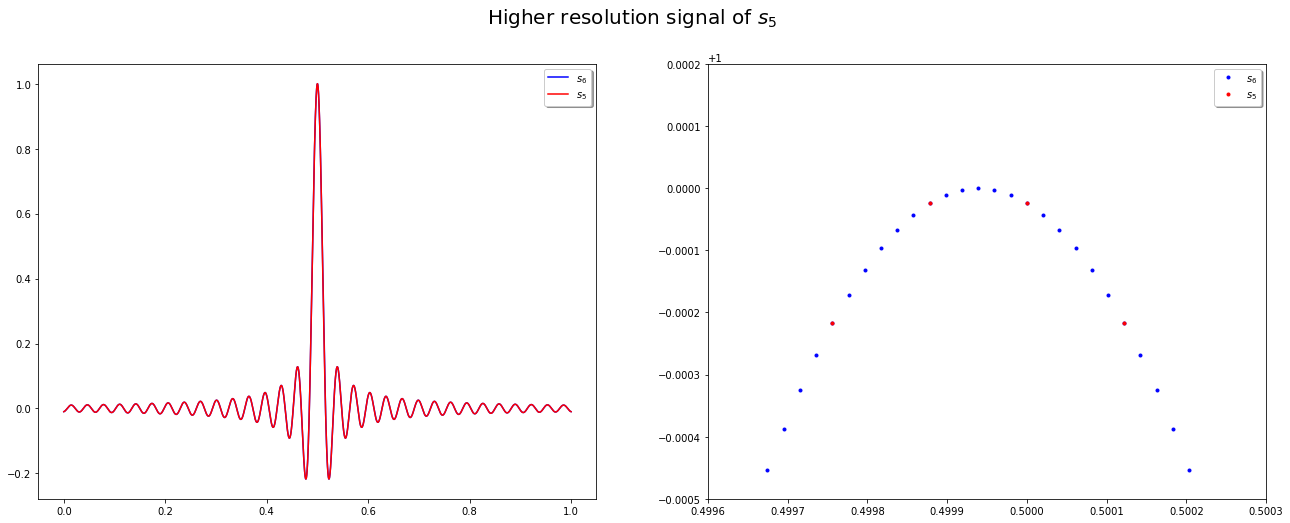

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(22, 8))
fig.suptitle(r'Higher resolution signal of $s_5$', fontsize = 20)

ax[0].plot(np.linspace(0, 1, len(reccon), endpoint = False), reccon, 'b', label = r'$s_6$')
ax[0].plot(np.linspace(0, 1, len(s5), endpoint = False), s5, 'r', label = r'$s_5$')
ax[0].legend(shadow=True, fancybox=True)

ax[1].plot(np.linspace(0, 1, len(reccon), endpoint=False), reccon, 'b.', label = r'$s_6$')
ax[1].plot(np.linspace(0, 1, len(s5), endpoint = False), s5, 'r.', label = r'$s_5$')
ax[1].set_ylim([0.9995, 1.0002])
ax[1].set_xlim([0.4996, 0.5003])
ax[1].legend(shadow=True, fancybox=True)

plt.show()

We observe from the rightmost plot that we obtained a signal with a higher resolution than the one provided in 'signals-csv'.

**3c)**

We want to show that there exists $\hat{a}_h$ such that

\begin{align*}
    c_k(D_{\frac{n}{2}}) = N \hat{a}_h c_k(D_n)
\end{align*}

by **2e)**, $D_{\frac{n}{2}}$ is in the translation space. Assume $h \in \{0, 1, ...,\frac{n}{2}\}$

\begin{align*}
    c_k(D_{\frac{n}{2}}) &= N \hat{a}_h c_k(D_n) \\
    \frac{1}{n+1} &= 2n \hat{a}_h \frac{1}{2n+1} \\
    \hat{a}_h &= \frac{2n + 1}{2n(n+1)}
\end{align*}

Assume $h \in \{\frac{n}{2}+1, ..., \frac{3n}{2}-1 \}$

\begin{align*}
    c_k(D_{\frac{n}{2}}) &= N \hat{a}_h c_k(D_n) \\
    0 &= 2n \hat{a}_h c_k(D_n) \\
\end{align*}

choose $\hat{a}_h = 0$ for these $h$. 

Assume $h \in \{\frac{3n}{2}, ..., 2n - 1\}$

\begin{align*}
    c_k(D_{\frac{n}{2}}) &= N \hat{a}_h c_k(D_n) \\
    \frac{1}{n+1} &= 2n \hat{a}_h \frac{1}{2n+1} \\
    \hat{a}_h &= \frac{2n + 1}{2n(n+1)}
\end{align*}

Meaning, defining

\begin{align*}
    \hat{a} = \frac{2n + 1}{2n(n+1)} \begin{bmatrix}
1\\
\vdots\\
1\\
0\\
\vdots\\
0 \\
1\\
\vdots\\
1\\\end{bmatrix}
\end{align*}

That is, $\frac{n}{2} + 1$ 1's, $n-1$ 0's and  $\frac{n}{2}$ 1's. (It is $0$-indexed by the way)

Using the inverse fourier matrix, one can easily compute the $a$ proving, by **2e)**, $D_{\frac{n}{2}} \in V_{2n, D_n}$

The basis for $V_{n, D_{\frac{n}{2}}}$, if we can express $\tau_n^j D_\frac{n}{2}$ we are good. 

Since $D_{\frac{n}{2}} \in V_{2n, D_n}$

\begin{align*}
    D_{\frac{n}{2}}(x) = \sum_{j = 0}^{2n-1} a _j \tau_{2n}^j D_n(x)
\end{align*}

because $\tau_n = \tau_{2n}^2$ we can

\begin{align*}
    \tau_n^i D_{\frac{n}{2}} &= \tau_n^i \sum_{j = 0}^{2n-1} a_j \tau_{2n}^j D_n(x)\\
    &=  \sum_{j = 0}^{2n-1} a_j \tau_{2n}^{j + 2i} D_n(x)\\
    &=  \sum_{j = 0}^{2n-1} \tilde a_{j} \tau_{2n}^{j} D_n(x)\\
\end{align*}

where $\tilde a_j$ is the looping shift ($2 i $-times) of $a_j$ in a natural way. 

Any element of the basis can be expressed, We have

\begin{align*}
    V_{n, D_{\frac{n}{2}}} \subset V_{2n, D_{n}}
\end{align*}

**3d)**

We want the orthogonal component of $V_{n, D_{\frac{n}{2}}}$ for decomposition. We will call it $W_{n, E_{\frac{n}{2}}}$. Define $E_{\frac{n}{2}}$ bby


\begin{align*}
    c_{h + zN}(E_{\frac{n}{2}}) = N \hat{b}_h c_{h + zN}(D_n) \quad \hat{b}_h = \hat{a}_{h + n \space (mod \space 2n)} e^{-\frac{h \pi i}{n}}
\end{align*}

for comparison, it will look like this


$$
    \hat{a} = \frac{2n + 1}{2n(n+1)} \begin{bmatrix}
1\\
\vdots\\
1\\
1\\
0\\
\vdots\\
0 \\
1\\
1\\
\vdots\\
1\\
\end{bmatrix}, \quad \hat{b} = \frac{2n + 1}{2n(n+1)} \begin{bmatrix}
0\\
\vdots\\
0\\
e^{-\frac{n}{2} \frac{\pi i}{n}}\\
\vdots\\
\vdots\\
\vdots\\
e^{-\frac{3n}{2} \frac{\pi i}{n}}\\
0\\
\vdots\\
0 \end{bmatrix}
$$


For convinience, we have tried to line up the the elements in both arrays to showcase it's form. Now, it is sufficient $E_{\frac{n}{2}}$ is orthogonal $D_{\frac{n}{2}}$. Note that the only coordinates where both $\hat{a}$ and $\hat{b}$ is nonzero is when $h = \frac{n}{2}, \frac{3n}{2}$

Using parseval identity we get

\begin{align*}
    \langle E_{\frac{n}{2}}, D_{\frac{n}{2}}\rangle &= \sum_{k \in \mathbb{Z}} c_k(E_{\frac{n}{2}}) \overline{c_k(D_{\frac{n}{2}})} \\
    &= \sum_{k \in \mathbb{Z}} N \hat{b}_h c_k(D_n) \overline{N \hat{a}_h c_k(D_n)} \\
    &= N^2 \sum_{k \in \mathbb{Z}} \hat{b}_h \overline{\hat{a}_h} |c_k(D_n)|^2 \\
    &= N^2 \sum_{k = -n}^n \hat{b}_h \overline{\hat{a}_h} \frac{1}{(2n+1)^2} \\
    &= \frac{N^2}{(2n+1)^2} \sum_{k = -n}^n \hat{b}_h \overline{\hat{a}_h} \\
    &= \frac{(2n)^2}{(2n+1)^2}  \left(\frac{2n + 1}{2n(n+1)} \right)^2 \left( e^{-\frac{n\pi i}{2n}} + e^{-\frac{3n\pi i}{2n}}\right) \\
    &=  \left(\frac{1}{n+1} \right)^2 \left( i + (-i)\right) \\
    &= 0
\end{align*}

They are orthogonal. 

Now we have seen that $\langle \tau_n^j f, \tau_n^k g\rangle =\langle \tau_n^{j-k} f, g\rangle $. Therefore we only need to prove $\langle \tau_n^j E_{\frac{n}{2}, D_{\frac{n}{2}}}\rangle = 0$. Indeed

\begin{align*}
    \langle \tau_n^j E_{\frac{n}{2}, D_{\frac{n}{2}}}\rangle &= \sum_{k \in \mathbb{Z}} c_k(\tau_n^j E_{\frac{n}{2}}) \overline{c_k(D_{\frac{n}{2}})} \\
    &= \sum_{k \in \mathbb{Z}} e^{-2 \pi i k \frac{j}{n}} c_k(E_{\frac{n}{2}}) \overline{c_k(D_{\frac{n}{2}})} \\
    &= N^2 \sum_{k \in \mathbb{Z}} e^{-2 \pi i k \frac{j}{n}} \hat{b}_h \overline{\hat{a}_h} |c_k(D_n)|^2 \\
    &= \frac{N^2}{(2n+1)^2} \sum_{k = -n}^n e^{-2 \pi i k \frac{j}{n}} \hat{b}_h \overline{\hat{a}_h}\\
    &= \frac{(2n)^2}{(2n+1)^2}  \left(\frac{2n+1}{2n(n+1)}\right)^2 \left( e^{-2 \pi i \frac{n}{2} \frac{j}{n}} e^{-\frac{n\pi i}{2n}} +e^{-2 \pi i \frac{3n}{2} \frac{j}{n}} e^{-\frac{3n\pi i}{2n}} \right) \\
    &= \left(\frac{1}{n+1}\right)^2 \left( (-1)^j i + (-1)^j (-i) \right) \\
    &= \left(\frac{1}{n+1}\right)^2 (-1)^j  \left( i  -i \right) \\
    &= 0
\end{align*}

By **2d)**, it is sufficient to show 

\begin{align*}
    \sum_{z \in \mathbb{Z}} |c_{h + zN'}( E_{\frac{n}{2}})|^2 \neq 0 \quad \forall h
\end{align*}

**Note**: $N' = \frac{N}{2} = n$

It is given that $c_{h + zN'}(E_{\frac{n}{2}}) = N \hat{b}_h c_{h + zN'}(D_n)$

\begin{align*}
    \sum_{z \in \mathbb{Z}} |c_{h + zN'}( E_{\frac{n}{2}})|^2 &= \sum_{z \in \mathbb{Z}} |N \hat{b}_{h + zN'} c_{h + zN'}( D_n)|^2 \\
    &= N^2 \sum_{z \in \mathbb{Z}} |\hat{b}_{h + zn}|^2 |c_{h + zn}( D_n)|^2 \\
    &= N^2 \sum_{z \in \mathbb{Z}} |e^{-\frac{h \pi i}{n}}|^2|\hat{a}_{h + n + zn}|^2 |c_{h + zn}( D_n)|^2 \\
    &=N^2 \sum_{z \in \mathbb{Z}}|\hat{a}_{h + (z+1)n}|^2 |c_{h + zn}( D_n)|^2 \\
\end{align*}

Regardless of the value of $h$, either $\hat{a}_h$ or $\hat{a}_{h+n}$ is nonzero. Also, there exists atleast one $a$ such that $c_{h+an}(D_n)$ is nonzero. Since everything is positive, this is a sum with atleast one positive term, making it strictly bigger than zero. By **2d)**, the translates of $E_{\frac{n}{2}}$ are linear independent. 


**3e)**

Proceeding further, we will like to decompose a signal $s$ projected onto $V_{2n, D_n}$ into its components belonging to the scale space, $V_{n, D_{\frac{n}{2}}}$, and the wavelet space, $W_{n, E_{\frac{n}{2}}}$. The decomposition can be formalized:

\begin{align*}
s = \sum_{j = 0}^{2n - 1} a_j \tau_{2n}^j D_{n}(x) = \sum_{j = 0}^{n - 1} \alpha_j \tau_{2n}^j D_{\frac{n}{2}}(x) \space \oplus \space \sum_{k = 0}^{n - 1} \beta_k \tau_{2n}^k E_{\frac{n}{2}}(x) 
\end{align*}

In item **3d)** we proved that $V_{n, D_{\frac{n}{2}}}$ and $W_{n, E_{\frac{n}{2}}}$ are orthogonal subsets of $V_{2n, D_n}$. Furthermore, $\text{rank}(V_{n, D_{\frac{n}{2}}}) + \text{rank}(W_{n, E_{\frac{n}{2}}}) = 2n = \text{rank}(V_{2n, D_n})$, which implies that the scale space and the wavelet space are orthogonal compliments. Thus, the right hand side of the expression above is a direct sum. This property will be used to decompose the signal. 

Firstly, we project the signal down onto the space $V_{n, D_{\frac{n}{2}}}$. Then, since we are working with orthogonal compliments knowing the projection onto the scale space and the signal itself, uniquely defines the signals component in the wavelet space.

<AxesSubplot:xlabel='x'>

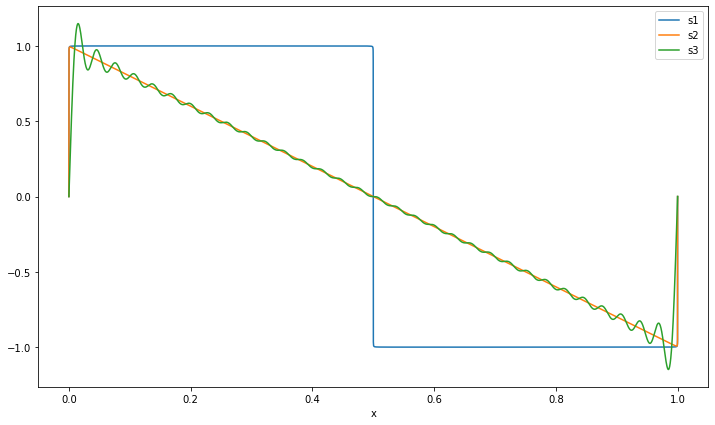

In [52]:
df.plot('x', ['s1','s2','s3'], figsize = (12, 7) )

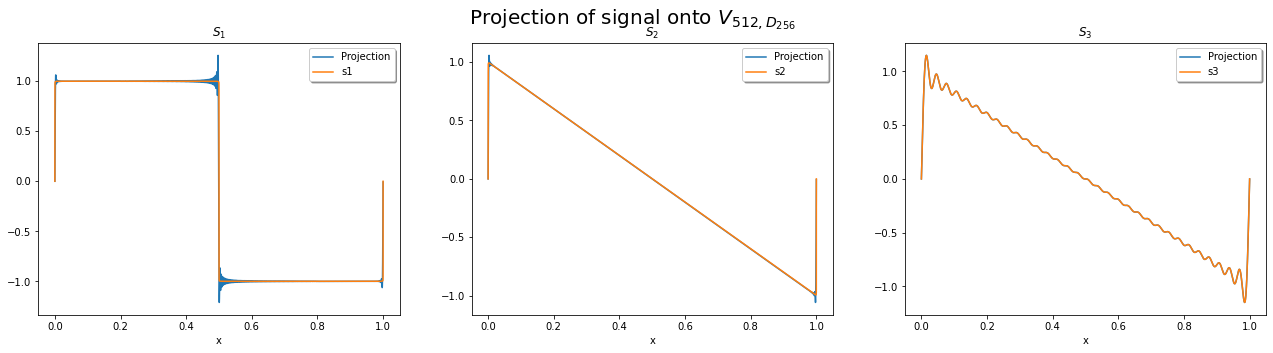

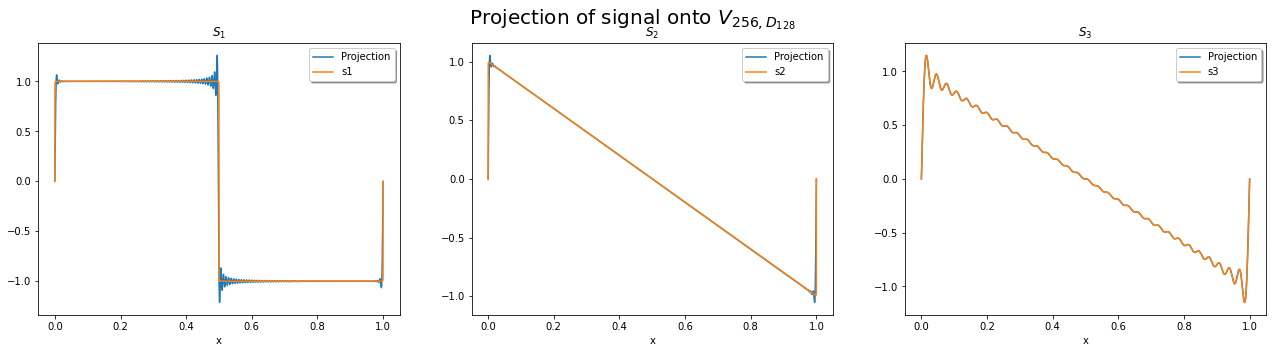

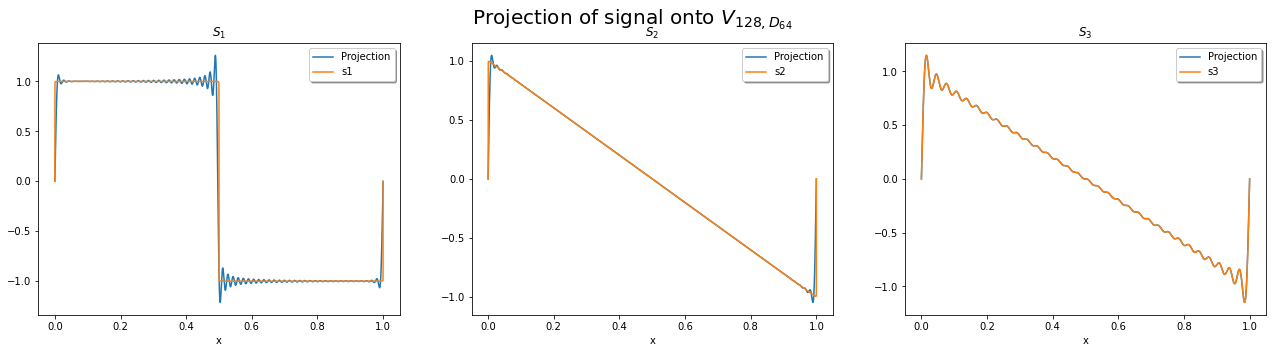

In [53]:
for j in range(1, 4):
    fig, ax = plt.subplots(1, 3, figsize=(22, 5))
    n = 512 // 2**j
    fig.suptitle('Projection of signal onto $V_{ %d, D_{ %d } }$'%(2*n, n), fontsize = 20)

    X = np.linspace(0, 1, 100000, endpoint=False)
    ckf = np.ones(len(X), dtype=complex) * 1/(2*n + 1)

    for i in range(0, 3):
        s = df[f's{i+1}'].to_numpy()

        step_size = len(s) // (2 * n)
        sample = s[::step_size]

        a = interpolate_signal(sample, ckf)
        g = reconstrucing_signal(a, ckf)

        ax[i].plot(X, g, label='Projection')
        ax[i].title.set_text(r'$S_{%d}$'%(i+1))
        df.plot('x', f's{i+1}', ax=ax[i])
        ax[i].legend(shadow = True)

In [54]:
def compliment(g, s, n):
    '''
    input:
        g: one part of direct sum
        s: signal
        n: order of Dirichlet kernel
    output:
        compliment of g
    '''
    N = len(g)
    n *= 2

    ckf = np.ones(N, dtype= complex) * 1/(2*n + 1)
    step_size = len(s) // (2*n)
    sample = s[::step_size]

    a = interpolate_signal(sample, ckf)
    g_vals = reconstrucing_signal(a, ckf)

    return g_vals - g

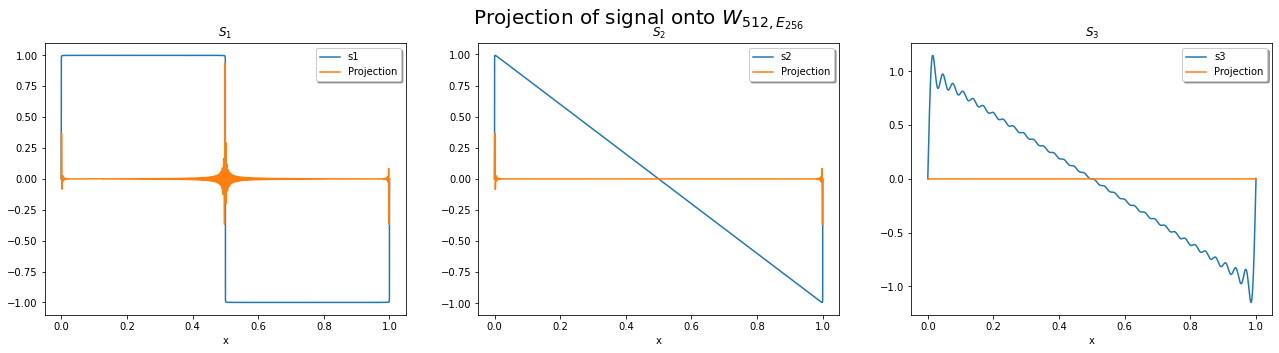

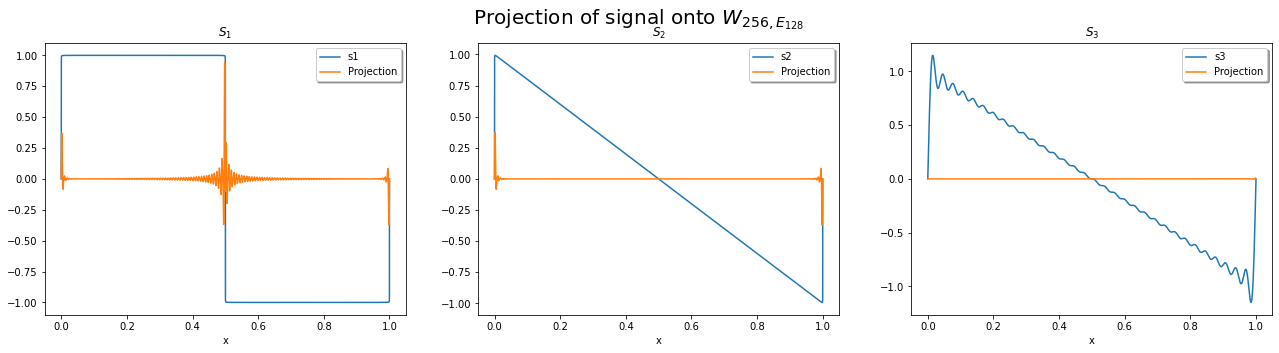

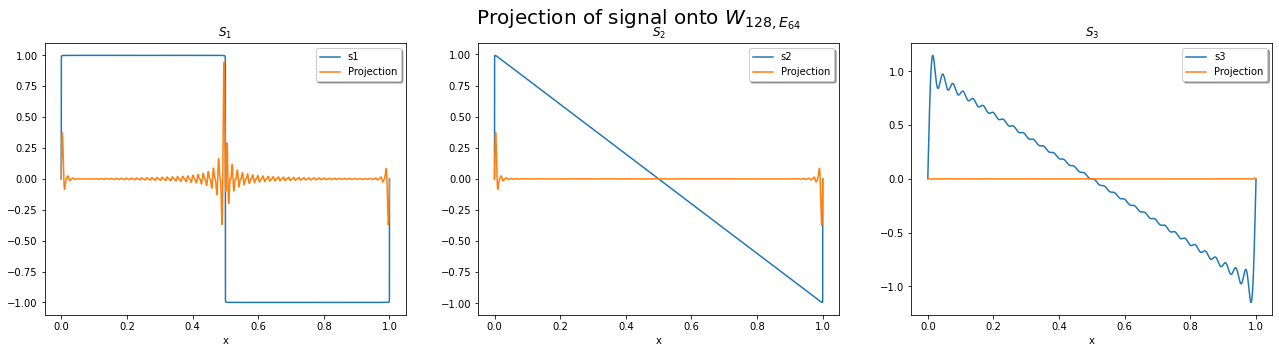

In [55]:
for j in range(1, 4):
    fig, ax = plt.subplots(1, 3, figsize=(22, 5))
    n = 512 // 2**j
    fig.suptitle('Projection of signal onto $W_{ %d, E_{ %d } }$'%(2*n, n), fontsize = 20)

    X = np.linspace(0, 1, 100000, endpoint=False)
    ckf = np.ones(len(X), dtype=complex) * 1/(2*n + 1)

    for i in range(0, 3):
        s = df[f's{i+1}'].to_numpy()

        step_size = len(s) // (2 * n)
        sample = s[::step_size]
        
        a = interpolate_signal(sample, ckf)
        g = reconstrucing_signal(a, ckf)

        g_comp = compliment(g, s, n)

        df.plot('x', f's{i+1}', ax=ax[i])
        ax[i].title.set_text(r'$S_{%d}$'%(i+1))
        ax[i].plot(X, g_comp, label='Projection')
        ax[i].legend(shadow = True)

We will always need the scale space to reconstruct the signal, atleast for a somewhat normal signal. The wavelet is used to represent abrupt changes, i.e high frequencies. When the derivative is basicly $\pm \infty$, we will need the wavelet space. For $s_1$, we need it because of the sudden changes at the start and the middle. This also applies to $s_2$. Now this doesn't apply to $s_3$ since the frequencies aren't high enough. We don't need the wavelet space to reconstruct the $s_3$ accurately.

### **Task 4**

We will now proceed to preform image decomposition utilizing multivariete $FFT$. On a 2D set of data, $\Theta \in \mathbb{C}^{N_1 \times N_2}, \space N_1, N_2 \in \mathbb{N}$, the 2D $DFT$ can be expressed as

\begin{align*}
\hat{F}_{k_{1}, k_{2}} &:=\frac{1}{N_{1} N_{2}} \sum_{j_{1}=0}^{N_{1}-1} \sum_{j_{2}=0}^{N_{2}-1} F_{j_{1}, j_{2}} \mathrm{e}^{-2 \pi \mathrm{i}\left(j_{1} k_{2} / N_{1}+j_{2} k_{2} / N_{2}\right)} \\
=& \hat{F}_{\boldsymbol{k}}=\frac{1}{\operatorname{det}(\operatorname{diag}(\boldsymbol{N}))} \sum_{j=(0,0)}^{\left(N_{1}, N_{2}\right)} F_{j} \mathrm{e}^{-2 \pi \mathrm{i} j^{\top}\left((\operatorname{diag}(\boldsymbol{N}))^{-1} \boldsymbol{k}\right)}, \\
& k_{1}=0, \ldots, N_{1}-1, k_{2}=0, \ldots, N_{2}-1, \quad \boldsymbol{k}=\left(k_{1}, k_{2}\right)^{\top}, \boldsymbol{j}=\left(j_{1}, j_{2}\right)^{\top}, \boldsymbol{N}=\left(N_{1}, N_{2}\right)^{\top}
\end{align*}

More compact, this can be represented by the vector $\hat{\Theta}=\mathcal{F}_{N_{1}} \Theta \mathcal{F}_{N_{2}}$. Further, the k'th entry og $\hat{\Theta}$, will be a phasor of the form $\hat{\Theta}_{\boldsymbol{k}} = |\hat{\Theta}_{\boldsymbol{k}}| e^{i \eta_{\boldsymbol{k}}}$. The defining data, i.e. the magnitude, $|\hat{\Theta}_{\boldsymbol{k}}|$, and the phase, $\eta_{\boldsymbol{k}}$, can be stored in a magnitude matrix, $M = (|\hat{\Theta}_{\boldsymbol{k}}|)_{\boldsymbol{k}}$, and a phase matrix, $P = (\eta_{\boldsymbol{k}})_{\boldsymbol{k}}$.

**4a)**

Continuing our numerical adventure, we will preform such magnitude/phase decompositions of the $DFT$ of two images. Furthermore, we will exchange the phases between the two pictures 'barbara.gif' and 'klaus.gif'.

In [56]:
# Non-dithered images
barbara = image.imread('project2-data/barbara.gif')
klaus = image.imread('project2-data/klaus.gif')

# Dithered images
yarimton = image.imread('project2-data/Yarimton-dithered.png')
lighthouse = image.imread('project2-data/lighthouse-dithered.png')
munkholmen = image.imread('project2-data/munkholmen-dithered.png')

# Removing unnecessary dimention
yarimton = yarimton[:, :, 0]

In [57]:
def split_fft2(fft2):
    '''
    input: 
        fft2: 2D dft of image
    output:
        amplitudes: matrix containing magnitudes
        phase: matrix containing phases
    '''
    amplitudes = np.abs( fft2 )
    phase = np.angle( fft2 )

    return amplitudes, phase

In [58]:
fftBarbara = np.fft.fft2( barbara )
fftKlaus = np.fft.fft2( klaus )

ampsBarbara, phaseBarbara = split_fft2( fftBarbara )
ampsKlaus, phaseKlaus = split_fft2( fftKlaus )

newBarbara = np.fft.ifft2( ampsBarbara * np.exp( 1j * phaseKlaus ) )
newKlaus = np.fft.ifft2( ampsKlaus * np.exp( 1j * phaseBarbara ) )

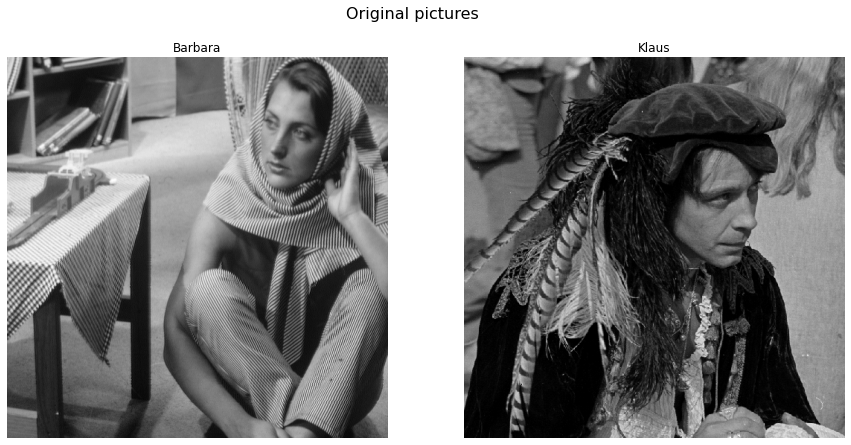

In [59]:
fig, ax = plt.subplots(1, 2, figsize = (15, 7))
fig.suptitle('Original pictures', fontsize = 16)

ax[0].axis('off')
ax[0].title.set_text('Barbara')
ax[0].imshow(barbara, cmap = 'gray')
ax[1].axis('off')
ax[1].title.set_text('Klaus')
ax[1].imshow(klaus, cmap = 'gray')
plt.show()

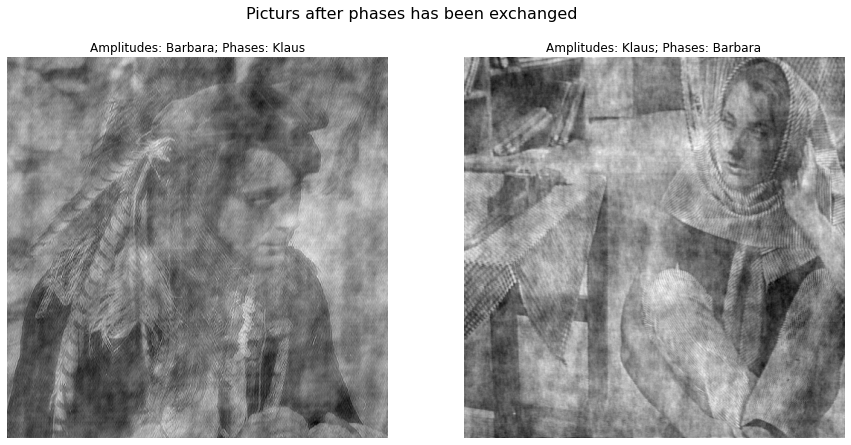

In [60]:
fig, ax = plt.subplots(1, 2, figsize = (15, 7))
fig.suptitle('Picturs after phases has been exchanged', fontsize = 16)

ax[0].axis('off')
ax[0].title.set_text('Amplitudes: Barbara; Phases: Klaus')
ax[0].imshow(newBarbara.real, cmap = 'gray')
ax[1].axis('off')
ax[1].title.set_text('Amplitudes: Klaus; Phases: Barbara')
ax[1].imshow(newKlaus.real, cmap = 'gray')
plt.show()

We immediately discern, that Klaus and Barbara seems to have interchanged their positions on the screen. We clearly recognize Klaus on the left and Barbara on the right. From these observations it looks like the phase matrix, $P$, carries more information about the original image than the magnitude matrix. 

**4b)**

Moving on, we will like to utilize the multidimensional $DFT$ to smoothen a dithered halftone picture. Concerning images, high frequencies represents areas with high contrasts, i.e. colors and tones are changing rapidly. Thus, removing the black dots on the dithered picture, is a matter of removing the high frequencies of the image. To do so we will apply a low pass Gaussian Filter to a slightly modified $DFT$ of the image in consideration. We use the discription "slightly modified", because the filter is not applied to the $DFT$ of the image, but rather a shifted version of the $DFT$. By shifting the $DFT$ we obtain a matrix, where the low frequencies are concentrated in the center of the matrix. Applying the Gaussian filter to this shifted $DFT$, we can remove the high frequencies on th edges. Furthermore, we apply the inverse shift function before computing the inverse $DFT$. Thereby, we obtain a smoothe version of the before dithered picture. 

In [61]:
def gaussian_low_pass_filter(img, r):
    '''
    input: 
        img: original image array
        r: rate of smoothening 
    output:
        LPF_mask: low-pass filter mask using gaussian smoothening
    '''
    m, n = img.shape

    y = np.arange(m)
    x = np.arange(n)

    dy = m/r
    dx = n/r

    xmask = np.exp(-(x-n/2)**2 / (2*dx**2))
    ymask = np.exp(-(y-m/2)**2 / (2*dy**2))

    LPF_mask = np.outer(ymask, xmask) #low-pass filter mask
    return LPF_mask

def remove_dither(img, r):
    '''
    input:
        img: image array
        r: rate of smoothning
    output:
        img: original image with removed dithering 
    '''
    img = np.fft.fft2(img)
    img = np.fft.fftshift(img) * gaussian_low_pass_filter(img, r)
    img = np.fft.ifftshift(img)
    img = np.fft.ifft2(img)
    return img

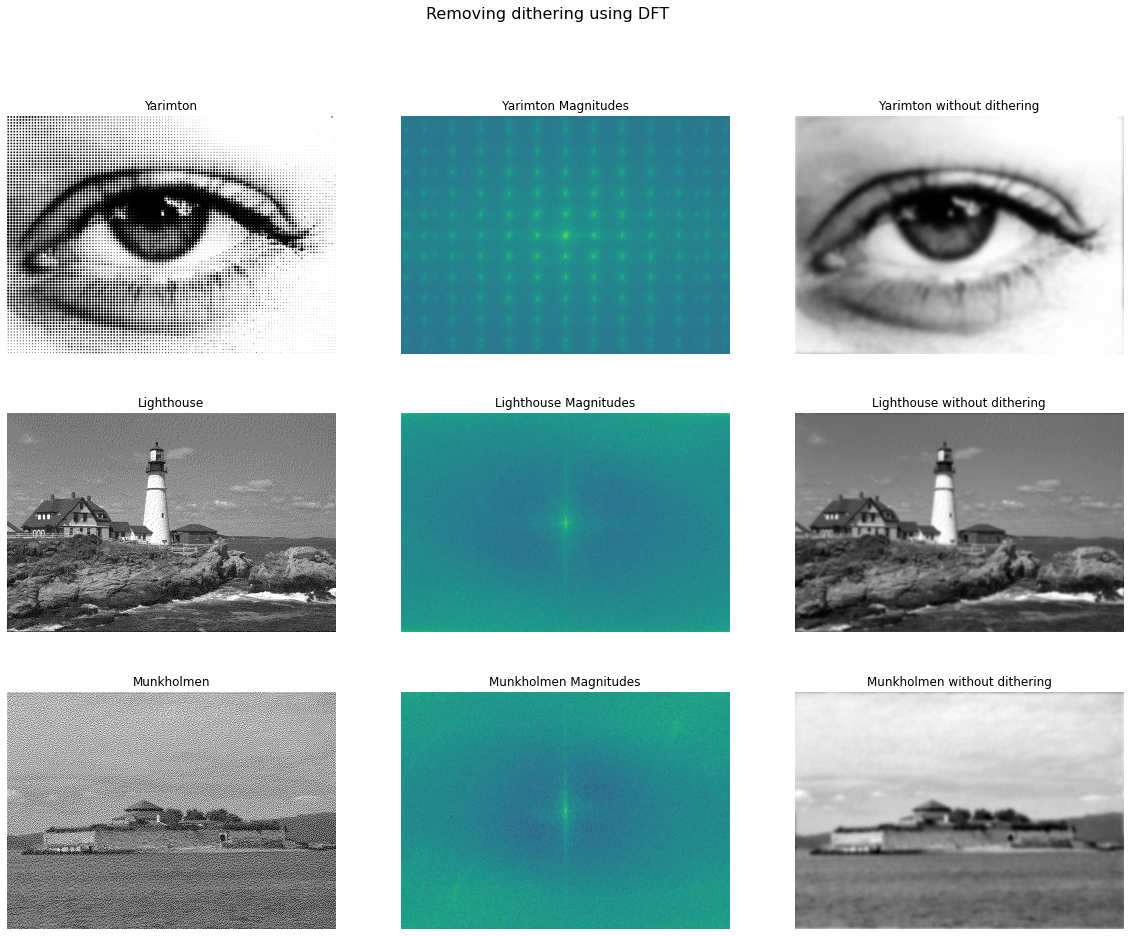

In [62]:
img = [yarimton, lighthouse, munkholmen]
titles = ['Yarimton', 'Lighthouse', 'Munkholmen']
R = [48, 14, 17]

fig, ax = plt.subplots(3, 3, figsize = (20, 15))

fig.suptitle('Removing dithering using DFT', fontsize = 16)

for i in range(3):
    ax[i, 0].imshow(img[i].real, cmap = 'gray')
    ax[i, 0].title.set_text(titles[i])
    ax[i, 0].axis('off')
    ax[i, 1].imshow(np.log( scipy.fft.fftshift( split_fft2( scipy.fft.fft2(img[i]) )[0] ).real ))
    ax[i, 1].title.set_text(titles[i] + ' Magnitudes')
    ax[i, 1].axis('off')
    
    ax[i, 2].imshow(remove_dither(img[i], R[i]).real, cmap = 'gray')
    ax[i, 2].title.set_text(titles[i] + ' without dithering')
    ax[i, 2].axis('off')

plt.show()

**4c)**

Our image is in $\mathbb{C}^{N_1 \times N_2}$. We need that our function $F$, which generates the translation space, must be defined on a $2$-dimensional torus, $\mathbb{T}^2 = [0,1)^2$


Define $F(x) = f_1 \otimes f_2(x)=f_1(x_1)f_2(x_2)$, where $x$ is an $(N_1 + N_2)$-vector, and $x = \begin{bmatrix}x_1\\x_2\end{bmatrix}$

Now $F$ will have translates in both coordinates, that is 

\begin{align*}
    \tau_N^J F(x) &:= \tau_{N_1}^{j_1} f_1(x_1)  \tau_{N_2}^{j_2} f_2(x_2)\\
    &= f_1\left(x_1 - \frac{j_1}{N_1}\right) f_2\left(x_2 - \frac{j_2}{N_2}\right)\\
\end{align*}

Therefore the translation space is given by

\begin{align*}
    V_{N,F} = \text{span}\left \{ \tau_N^J F \right \}_{J} = \text{span}\left \{ \tau_{N_1}^{j_1} f_1 \otimes \tau_{N_2}^{j_2} f_2 \right \}_{ j_1, j_2 = 0}^{N_1 - 1, N_2 -1} , \quad N = (N_1, N_2), \quad J = (j_1, j_2) 
\end{align*}

**4d)**

Considering the dimensions of $V_{2n, D_n}, V_{n, D_{\frac{n}{2}}}, W_{n, E_{\frac{n}{2}}}$ and the fact that $V_{n, D_{\frac{n}{2}}}, W_{n, E_{\frac{n}{2}}}$ orthogonal (complement) we get. 

\begin{align*}
    V_{2n, D_n} = V_{n, D_{\frac{n}{2}}} \oplus W_{n, E_{\frac{n}{2}}}
\end{align*}


A basis for our space is given by

$$
    V_{N, D_n \otimes D_m} = \text{span} \{ \tau_{2n}^{j_1} D_n \otimes \tau_{2m}^{j_2} D_m \} _{ j_1, j_2 = 0}^{2n - 1, 2m -1} = V_{2n, D_n} \otimes V_{2m, D_m}
$$

Now we have seen that the translation spaces of decompose. 

\begin{align*}
    V_{2n, D_n} \otimes V_{2m, D_m} &= (V_{n, D_{\frac{n}{2}}} \oplus W_{n, E_{\frac{n}{2}}}) \otimes (V_{m, D_{\frac{n}{2}}} \oplus W_{n, E_{\frac{n}{2}}})
\end{align*}

With the properties of tensor product can be written as a basis for the total space is given by

$$
    \text{span} \left \{ \begin{array}{ll}
\tau_{n}^{j_1} D_{\frac{n}{2}} \otimes \tau_m^{j_2} D_{\frac{m}{2}} \\
\tau_{n}^{j_1} D_{\frac{n}{2}} \otimes \tau_m^{j_2} E_{\frac{m}{2}} \\
\tau_{n}^{j_1} E_{\frac{n}{2}} \otimes \tau_m^{j_2} D_{\frac{m}{2}} \\
\tau_{n}^{j_1} E_{\frac{n}{2}} \otimes \tau_m^{j_2} E_{\frac{m}{2}} \\
\end{array} \right \}_{j_1, j_2}
$$


The scale space, or the LL-subband, is by definition given by the vectors \text{span}ned by the first entry, that is. 

$$
    \text{span} \{ \tau_{n}^{j_1} D_{\frac{n}{2}} \otimes \tau_m^{j_2} D_{\frac{m}{2}} \}_{j_1, j_2}
$$

or, in other words

\begin{align*}
    V_{n, D_\frac{n}{2}} \otimes V_{m, D_{\frac{m}{2}}}
\end{align*}

Usually, a block representation is used where

\begin{align*}
    V_{2n, D_n} \otimes V_{2m, D_m} \simeq  \begin{bmatrix} V_{n, D_\frac{n}{2}} \otimes V_{m, D_{\frac{m}{2}}} & W_{n, E_\frac{n}{2}} \otimes V_{m, D_{\frac{m}{2}}} \\
    W_{n, E_\frac{n}{2}} \otimes V_{m, D_{\frac{m}{2}}} & W_{n, D_\frac{n}{2}} \otimes W_{m, E_{\frac{m}{2}}}\end{bmatrix}
\end{align*}

Now we weren't able do this implementaion properly, but we will explain how we would have done it. Using the 2D image,  

Tensor property of fourier coefficient

by definition:

\begin{align}
    c_{\bf{k}} (F) &= \iint_{\mathbb{T}^2} e^{-2 \pi i \bf{k} \cdot \bf{x}} F(\textbf{x}) d\bf{x}\\
    &= \iint_{\mathbb{T}^2} e^{-2 \pi i k_1 x_1} e^{-2 \pi i k_2 x_2}  f_1 \otimes f_2(\textbf{x})  dx_1 dx_2\\
    &= \int_0^1\int_0^1 e^{-2 \pi i k_1 x_1} e^{-2 \pi i k_2 x_2}  f_1(x_1)f_2(x_2)  dx_1 dx_2\\
    &= \int_0^1 e^{-2 \pi i k_1 x_1} f_1(x_1)  dx_1  \int_0^1 f_2(x_2) e^{-2 \pi i k_2 x_2}dx_2\\
    &= c_{k_1}(x_1) c_{k_2}(x_2)\\
\end{align}

This means that our fourier coefficients will now be a matrix with a rectangle of nonzero values. These values will be $\frac{1}{(n+1)(m+1)}$ when in the translation space $V_{N, D_{\frac{n}{2}} \otimes D_{\frac{m}{2}}}$. Using the same procedure in **3e)**, we construct $a_\textbf{h}$, which also will be an array, by Hadamard division (entryvise division). That is, if $s$ is the signal 

\begin{align}
    \hat{a}_{\textbf{h}} = FFT(s) \oslash nm \sum_{z\in \mathbb{Z}^2} c_{\textbf{h}+z\textbf{N}(F)}
\end{align}


In two dimensions, we think the two dimensional condition from **3d)** gives 

\begin{align}
    \hat{b}_{\textbf{h}} = \hat{a}_{\textbf{h + N}} e^{- 2 \pi i \left(\frac{h_1}{n}+ \frac{h_2}{m} \right)}
\end{align}

With $\hat{a}_h, \hat{b}_h$ one can represent the LL and the HH-subband. Now to create LH and HL maybe we also can construct?

\begin{align}
    \hat{c}_{\textbf{h}} = \hat{a}_{\textbf{h + (n,0)}} e^{- 2 \pi i \frac{h_1}{n}}
\end{align}

\begin{align}
    \hat{d}_{\textbf{h}} = \hat{a}_{\textbf{h + (0,m)}} e^{- 2 \pi i \frac{h_2}{m}}
\end{align}

This is just a guess. 

But say we had the decomposition. If we were to remove the high frequencies in both direction, that is remove the HH subband, alot of the dithering will be removed. Due to the dithering, between any points of color, there are holes which creates large frequencies. Without these frequencies, the picture should smoothe out. 